In [1]:
import datetime
print datetime.datetime.now()

2019-06-06 10:58:22.349000


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<\style>"))

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
from __future__ import division
import importlib 

import statsmodels.api as sm; from statsmodels.iolib.summary2 import summary_col
import pandas as pd ; pd.set_option("display.max_columns",200);  pd.set_option("display.max_rows",200); 
import numpy as np

In [6]:
store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/edp_2015_final.h5'
reaction_store_path = 'C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Data/hdf/reaction.h5'
Store = pd.HDFStore(store_path)

In [7]:
def load_fisc_i_by_year(year = 2014):
    df_fisci = pd.read_hdf(store_path, 'FISC_INDIVIDU_{}'.format(year))
    return df_fisci
def load_fisc_r_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_REVENU_{}'.format(year))
    return df_fiscr
def load_fisc_l_by_year(year = 2014):
    df_fiscr = pd.read_hdf(store_path, 'FISC_LOGEMENT_{}'.format(year))
    return df_fiscr

def load_df_fiscrevdet_by_year(year = 2015):
    df_fiscrevdet = pd.read_hdf(store_path, 'FISC_REVDET_{}'.format(year))
    return df_fiscrevdet

ir_2014 = importlib.import_module("IRPP_from_scratch_civil_union")
ir_2011 = importlib.import_module("IRPP_from_scratch_civil_union_{}".format(2011))

In [8]:
info_dict = {'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}

## Needed variables

In [9]:
nb_enf_max_for_annalysis = 6

In [10]:
threshold_byr_rbg = pd.DataFrame()
threshold_byr_rbg["2011"] = pd.Series([63233,73516,94451,115185,135941,150684])
threshold_byr_rbg["2014"] = pd.Series([58291,63530,73806,84103,94368,104633])

In [11]:
child_bool_list = ["child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)]
cumulative_child_bool_list = ["cumulative_child_{}".format(child) for child in  np.arange(1,nb_enf_max_for_annalysis+1)] 

In [12]:
thrsh_bool_list = ["Threshold_{}".format(thrsh) for thrsh in  threshold_byr_rbg["2011"]]

In [13]:
between_threshold_for_child_rank = ["Between_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
over_threshold_for_child_rank = ["Over_threshold_{}_child".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]
children_number =  ["child_{}".format(nb_child) for nb_child in range(1,nb_enf_max_for_annalysis+1)]

In [14]:
interaction_child_between_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, between_threshold_for_child_rank)]
interaction_child_over_threshold  = ["{}:{}".format(child,interaction) for child, interaction in zip(children_number, over_threshold_for_child_rank)]

In [15]:
threshold_byr_rbg

2011    2014
0   63233   58291
1   73516   63530
2   94451   73806
3  115185   84103
4  135941   94368
5  150684  104633

In [16]:
df_start = pd.read_hdf(u"C:/Users/IMPTEMP_A_PACIFIC/Desktop/EDP_2015/Programme/Réaction offre de travail/hdf/data_step_1_reaction_offre_travail.h5","fisci_fiscr_fiscrevdet")
print(df_start.shape)

(1522346, 362)


In [17]:
df_start["Delta_Rbg"] = df_start.Rbg_2014 - df_start.Rbg_2011
df_start["Delta_rbg_positif"] = (df_start.Delta_Rbg>0).astype("int")
df_start["Delta_rbg_negatif"] = (df_start.Delta_Rbg<0).astype("int")

df_start["Delta_NBPAC"] = df_start.NBPAC_2014 - df_start.NBPAC_2011
df_start["Delta_ZIMPOM"] = df_start.ZIMPOM14_2014 - df_start.ZIMPOM_2011


df_start["Age_wo_squared"] = df_start.Age_wo **2
df_start["Age_me_squared"] = df_start.Age_me ** 2 

df_start["Age_oldest_parent"] = df_start[["Age_me", "Age_wo"]].max(axis = 1)
df_start["Age_oldest_parent_squared"] = df_start.Age_oldest_parent**2

df_start["Parts_fiscales_enfants"] = ir_2011.parts_fiscales_enfants(df_start.NBPAC_2011)
df_start["ZTSAM_10_percent_2014"] =  df_start["ZTSAM_2014"]*0.9
df_start["ZTSAM_10_percent_2014"] =  df_start["ZTSAM_2014"]*0.9
df_start["Irpp_2014"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2014, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2014, df_start.Parts_fiscales_enfants))
df_start["Irpp_2014_plus_10_euros"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants))

df_start["Counterfactual_Irpp_2014"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2014, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2014, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2014_plus_10_euros"] =  np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2014+10, df_start.Parts_fiscales_enfants))
df_start["Irpp_2011"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2011, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2011, df_start.Parts_fiscales_enfants))
df_start["Irpp_2011_plus_10_euros"] = np.maximum(0, ir_2011.ir_avec_plafond_qf_enfant(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants) - ir_2011.decote_ir(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2011"] = np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2011, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2011, df_start.Parts_fiscales_enfants))
df_start["Counterfactual_Irpp_2011_plus_10_euros"] =  np.maximum(0, ir_2014.ir_avec_plafond_qf_enfant(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants) - ir_2014.decote_ir(df_start.Rbg_2011+10, df_start.Parts_fiscales_enfants))
df_start["MTR_2014"] = np.round((df_start.Irpp_2014_plus_10_euros - df_start.Irpp_2014)/10,3)
df_start["MTR_2011"] = np.round((df_start.Irpp_2011_plus_10_euros - df_start.Irpp_2011)/10,3)
df_start["Counterfactual_MTR_2014"
                     ] =  np.round((df_start.Counterfactual_Irpp_2014_plus_10_euros - df_start.Counterfactual_Irpp_2014)/10,2)
df_start["Counterfactual_MTR_2011"
                     ] = np.round((df_start.Counterfactual_Irpp_2011_plus_10_euros - df_start.Counterfactual_Irpp_2011)/10,2)


In [18]:
#Flatten thresholds
threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis]
flatten_thresholds = np.sort(threshold_byr_rbg.iloc[0:nb_enf_max_for_annalysis].values.flatten())
flatten_thresholds_list = list()
for counter in range(len(flatten_thresholds)-1):
    print(flatten_thresholds[counter], flatten_thresholds[counter+1])
    
    thrsh1, thrsh2 = flatten_thresholds[counter], flatten_thresholds[counter+1]
    flatten_thresholds_list.append("Flatten_thresholds_{}_{}".format(thrsh1, thrsh2))
    df_start["Flatten_thresholds_{}_{}".format(thrsh1, thrsh2)] = ((df_start.Rbg_2011>  thrsh1)& (df_start.Rbg_2011< thrsh2))
df_start["Flatten_thresholds_more_then_{}".format( thrsh2)] = (df_start.Rbg_2011> thrsh2).astype("int")
flatten_thresholds_list.append("Flatten_thresholds_more_then_{}".format(thrsh2))

(58291, 63233)
(63233, 63530)
(63530, 73516)
(73516, 73806)
(73806, 84103)
(84103, 94368)
(94368, 94451)
(94451, 104633)
(104633, 115185)
(115185, 135941)
(135941, 150684)


In [19]:



fisici = load_fisc_i_by_year(2014)
df_fisci_child = fisici[fisici.TYPE_FISC.isin(["A", "B", "C", "D", "E", "F", "G", "H"])]
df_fisci_child["Age"] = 2014 - df_fisci_child.ANAIS 
df_fisci_child = df_fisci_child.sort(['ID_FISC_FOY_DIFF', "Age"])


df_fisci_Elder = df_fisci_child.groupby("ID_FISC_FOY_DIFF").last()
df_fisci_Elder["Age_Elder_child"] = df_fisci_Elder.Age
df_fisci_Elder = df_fisci_Elder.reset_index()[["ID_FISC_FOY_DIFF","Age_Elder_child" ]]

df_fisci_Youngest = df_fisci_child.groupby("ID_FISC_FOY_DIFF").first()
df_fisci_Youngest["Age_Youngest_child"] = df_fisci_Youngest.Age
df_fisci_Youngest = df_fisci_Youngest.reset_index()[["ID_FISC_FOY_DIFF","Age_Youngest_child" ]]

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:


df_start["Not_touched_by_reform"] = (df_start.NBPAC_2011 == 0).astype("int")
for nb_enf in range(1,7): ### in modification
    df_start["Not_touched_by_reform".format(nb_enf)
          ] +=((df_start.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])
                *( df_start.NBPAC_2011 == nb_enf)).astype("float")
    
df_start["Delta_Rbg_times_not_touched_reform"] = df_start.Not_touched_by_reform * df_start.Delta_Rbg; df_start.shape

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\pandas\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


(1522346, 399)

In [21]:
fisc_logement = load_fisc_l_by_year(2014)
fisc_logement.OCC.value_counts(dropna=False)
fisc_logement["Proprietaire"] = fisc_logement.OCC == "P"
#fisc_logement["CSDEP"] = fisc_logement.CSDEP.replace({"2A": "40", "2B":"40"}).astype("int")

df_start["ID_FISC_LOG_DIFF"] = df_start.ID_FISC_LOG_DIFF_2014
df_start = pd.merge(df_start, fisc_logement, on = "ID_FISC_LOG_DIFF")
df_start.DEP = df_start.DEP.replace({"2A": "96", "2B":"96"}).astype("int")

In [22]:
df_start.shape

(1521762, 436)

###  Income sample selection

In [23]:
df_start.shape

(1521762, 436)

In [24]:
#Nouvelle version ou il faut appartenir à l'intervalle de revenu que sur un seule des deux années
df_start = df_start[((
            (df_start.Rbg_2011>50000)
            &(df_start.Rbg_2011<200000)
        )|(
            (df_start.Rbg_2014>50000)
            & (df_start.Rbg_2014<200000)))];print(df_start.shape)

(451572, 436)


In [25]:
low = 0.02
high = 0.98
quant_df_start = df_start.Delta_Rbg.quantile([low,high])
print(quant_df_start)
df_start = df_start[df_start.Delta_Rbg>quant_df_start.loc[low]]
df_start = df_start[df_start.Delta_Rbg<quant_df_start.loc[high]]
print(df_start.shape)

df_start = df_start[df_start.Rbg_2011>7000]
df_start = df_start[df_start.Rbg_2014>7000]
print(df_start.shape)

0.02   -49793.098
0.98    67614.864
dtype: float64
(433508, 436)
(429622, 436)


In [26]:
df_start = df_start[~(df_start.NBPERSM_2011 == 1 )] #Vire une seule personne dans le ménage
df_start = df_start[~(df_start.NBPERSM_2011 - df_start.NBPAC_2011  == 1 )]  # Vire les parents célibataires
df_start.shape

(414172, 436)

In [27]:
reg_df = df_start[(df_start.Age_wo<65)&(df_start.Age_me<65)] # Vire les papi mamies

In [28]:
reg_df.shape

(267913, 436)

In [29]:
reg_df = reg_df[reg_df.NBPAC_2011.isin(range(nb_enf_max_for_annalysis+1))] #Drop families with more than 6 children
reg_df.shape

(267806, 436)

In [30]:
# Drop non maried families
fisici = load_fisc_i_by_year(2014)
id_foy_diff = reg_df.ID_FISC_FOY_DIFF
fisci_2 = fisici[fisici.ID_FISC_FOY_DIFF.isin(id_foy_diff)]
print(fisci_2.CIDECI.value_counts())
to_drop = fisci_2.CIDECI.isin([ 'C','D', 'V', 'O'])
reg_df = reg_df[~reg_df.ID_FISC_FOY_DIFF.isin(to_drop)]
reg_df.shape

M    432365
A    384859
O     36374
C     24599
D      8693
V      1052
dtype: int64


(267806, 436)

In [31]:
reg_df_same_NBPAC = reg_df[(reg_df.NBPAC_2011 == reg_df.NBPAC_2014)]
reg_df_same_NBPAC.shape

(193555, 436)

In [32]:
### Add children age
reg_df_same_NBPAC = reg_df_same_NBPAC.merge(df_fisci_Youngest, on = "ID_FISC_FOY_DIFF", how = "left")
reg_df_same_NBPAC = reg_df_same_NBPAC.merge(df_fisci_Elder, on = "ID_FISC_FOY_DIFF",  how = "left")
reg_df_same_NBPAC.Age_Elder_child.fillna(0, inplace = True)
reg_df_same_NBPAC.Age_Youngest_child.fillna(0, inplace = True)
reg_df_same_NBPAC.shape

(193555, 438)

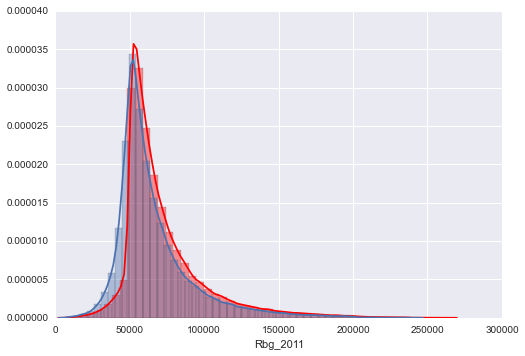

In [33]:
import seaborn as sns
sns.distplot(reg_df_same_NBPAC.Rbg_2014, color = "r")
sns.distplot(reg_df_same_NBPAC.Rbg_2011)

In [34]:
df = reg_df_same_NBPAC

### Triple diff

In [35]:
(df.ZVALM_2011<50).value_counts()

True     144841
False     48714
dtype: int64

In [36]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number+ #below_threshold_for_child_rank+interaction_child_below_thresholds
                  between_threshold_for_child_rank+children_number+ over_threshold_for_child_rank+
                  interaction_child_between_threshold+interaction_child_over_threshold))
                                                                                        , reg_df_same_NBPAC)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     312.2
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:05:08   Log-Likelihood:            -2.1330e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193524   BIC:                         4.266e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [37]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.045         \\
Dependent Variable: & Delta_Rbg        & AIC:                & 4266032.8752  \\
Date:               & 2019-06-06 11:05 & BIC:                & 4266348.2481  \\
No. Observations:   & 193555           & Log-Likelihood:     & -2.1330e+06   \\
Df Model:           & 30               & F-statistic:        & 312.2         \\
Df Residuals:       & 193524           & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.045            & Scale:              & 2.1852e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &   Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &  6381.1242 &    83.2636 &  7

### Flatten thresholds

In [38]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     312.2
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:05:09   Log-Likelihood:            -2.1330e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193524   BIC:                         4.266e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [39]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.045         \\
Dependent Variable: & Delta_Rbg        & AIC:                & 4266032.8752  \\
Date:               & 2019-06-06 11:05 & BIC:                & 4266348.2481  \\
No. Observations:   & 193555           & Log-Likelihood:     & -2.1330e+06   \\
Df Model:           & 30               & F-statistic:        & 312.2         \\
Df Residuals:       & 193524           & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.045            & Scale:              & 2.1852e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &   Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &  6381.1242 &    83.2636 &  7

In [40]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df.query("ZVALM_2011<=50"))
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     221.5
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:05:11   Log-Likelihood:            -1.5896e+06
No. Observations:              145050   AIC:                         3.179e+06
Df Residuals:                  145019   BIC:                         3.180e+06
Df Model:                          30                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [41]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.044         \\
Dependent Variable: & Delta_Rbg        & AIC:                & 3179336.5512  \\
Date:               & 2019-06-06 11:05 & BIC:                & 3179642.9810  \\
No. Observations:   & 145050           & Log-Likelihood:     & -1.5896e+06   \\
Df Model:           & 30               & F-statistic:        & 221.5         \\
Df Residuals:       & 145019           & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.044            & Scale:              & 1.9350e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &    Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &   6658.1305 &    97.1653 & 

In [42]:
hardcoded_over = ["Over_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]
hardcoded_between = ["Between_{}_X_{}_child".format(child,child) for child in range(1,nb_enf_max_for_annalysis+1)]

for child in range(1,7):
    df["Over_{}_X_{}_child".format(child,child)] = df["Over_threshold_{}_child".format(child)] * (df["NBPAC_2011"]==child)
    df["Between_{}_X_{}_child".format(child,child)] = df["Between_threshold_{}_child".format(child)] * (df["NBPAC_2011"]==child)

In [43]:
df["Proprietaire"] = df.OCC == "P"

In [44]:
df.DATACHEV = df.DATACHEV.clip(1900,2012)

In [45]:
df["House_age"] = 2012 - df.DATACHEV

In [46]:
df["Social_housing"] = ~df.HLMSEM.isnull()

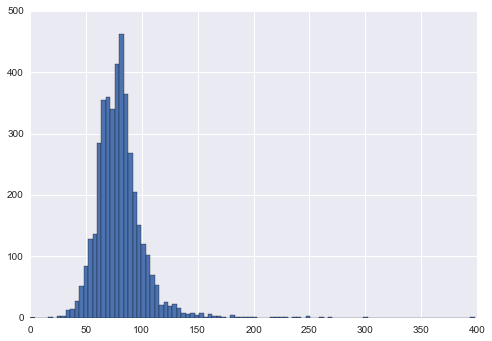

In [47]:
df.query("Social_housing").SURFTOT.hist(bins = 100)

In [48]:
df.CNE.value_counts().head(20)

63     1565
109    1360
115    1218
113    1218
4      1184
555    1132
118    1117
88     1109
114    1004
69      990
33      979
112     979
51      970
1       952
117     951
7       924
116     915
48      912
120     884
12      884
dtype: int64

In [49]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} ++Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(CNE)+ C(DEP) ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                 2.960e+15
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:06:36   Log-Likelihood:            -2.1303e+06
No. Observations:              193480   AIC:                         4.263e+06
Df Residuals:                  192456   BIC:                         4.273e+06
Df Model:                        1023                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [50]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.059         \\
Dependent Variable: & I(Delta_Rbg)     & AIC:                & 4262597.9526  \\
Date:               & 2019-06-06 11:07 & BIC:                & 4273015.0324  \\
No. Observations:   & 193480           & Log-Likelihood:     & -2.1303e+06   \\
Df Model:           & 1023             & F-statistic:        & 2.960e+15     \\
Df Residuals:       & 192456           & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.064            & Scale:              & 2.1541e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &    Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &    0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &  12635.5562 &  1157.9652 &

In [51]:
%%time
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(hardcoded_over + hardcoded_between)),
        df)
fit1 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + hardcoded_over + hardcoded_between)),
        df)
fit2 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join( flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit3 = m.fit(cov_type="HC1")




m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join( 
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_4 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(
                  children_number[1:] + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("NBPAC_2011>=1"))
fit_5 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_6 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)


fit_6_1 = m.fit(cov_type="HC1")

m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared +Age_Elder_child+Age_Youngest_child\
                                           +Proprietaire +SURFTOT + Social_housing + House_age ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_7 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(CNE) ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_8 = m.fit(cov_type="HC1")


m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(CNE)+ C(DEP) ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df)
fit_9 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"))
fit_10 = m.fit(cov_type="HC1")



m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child ".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)"))
fit_11 = m.fit(cov_type="HC1")

m = sm.OLS.from_formula("(Delta_Rbg)~   {} +Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + hardcoded_over + hardcoded_between)),
        df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==0)"))
fit_12 = m.fit(cov_type="HC1")



#print(summary_col([fit1, fit2,fit3, fit_4],model_names =None, stars = True))



Wall time: 2min 48s


In [52]:
summary = summary_col([fit1, fit2,fit3, fit_4, fit_5, fit_6, fit_6_1, fit_7, fit_8, fit_9, fit_10, fit_11, fit_12], stars = True,float_format='%.2f',
                  info_dict=info_dict,
                model_names = ["Only_treatment_var","Treatmt_var_w_child_var", "Treatment_var_w_income_thrsh_var", "Triple_diff", 
                               "Triple_diff_w_child_only", "Tripl_age_parents", "Triple_age", "Triple_control_local", "Triple_countrol_housing","Triple_control_local_dep", 
                               "Triple_no_othr_income", "Triple_noi_positive_delta","Triple_noi_negative_delta" ])

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\statsmodels\iolib\summary2.py:376

In [53]:
import copy
summary_save = summary

In [54]:

summary = copy.copy(summary_save)

In [55]:
code_communes = list(df.CNE.value_counts().sort_index().index)
code_deps = list(df.DEP.value_counts().sort_index().index)



df_table_reg = summary.tables[0]

loc_indexes = list()
for com in ["C(CNE)[T.{}]".format(code_com) for code_com in code_communes[1:]]: #First code taken as reference
    loc_indexes.append(df_table_reg.index.get_loc(com))
for com in ["C(DEP)[T.{}]".format(code_dep) for code_dep in code_deps[1:]]: #First code taken as reference
    loc_indexes.append(df_table_reg.index.get_loc(com))
loc_indexes = np.array(loc_indexes)



df_table_reg = df_table_reg.reset_index()

to_drop_indexes = df_table_reg.iloc[loc_indexes+1].index
df_table_reg = df_table_reg.drop(to_drop_indexes)
df_table_reg = df_table_reg.set_index("index")
df_table_reg = df_table_reg.drop(["C(CNE)[T.{}]".format(code_com) for code_com in code_communes]+["C(DEP)[T.{}]".format(code_dep) for code_dep in code_deps[1:]])
head_df = df_table_reg.iloc[:-2]
head_df.loc["Code_departement"] = [""]*9+["   X"]*1+[""]*3
head_df.loc["Code_commune"] = [""]*8+["  X"]*2+ [""]*3
df_table_reg = head_df.append(df_table_reg.iloc[-2:]) 
summary.tables = [df_table_reg]
print(summary)


                                         Only_treatment_var Treatmt_var_w_child_var Treatment_var_w_income_thrsh_var Triple_diff Triple_diff_w_child_only Tripl_age_parents  Triple_age Triple_control_local Triple_countrol_housing Triple_control_local_dep Triple_no_othr_income Triple_noi_positive_delta Triple_noi_negative_delta
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_Elder_child                                                                                                                                                             -121.70***  -120.43***           -118.72***              -115.68***               -61.54***             29.37                     -26.88                   
               

C:\Users\IMPTEMP_A_PACIFIC\Desktop\WinPython-64bit-2.7.10.2\WinPython-64bit-2.7.10.2\python-2.7.10.amd64\lib\site-packages\IPython\kernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
print(summary.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccccccccccc}
\hline
                                         & Only_treatment_var & Treatmt_var_w_child_var & Treatment_var_w_income_thrsh_var & Triple_diff & Triple_diff_w_child_only & Tripl_age_parents &  Triple_age & Triple_control_local & Triple_countrol_housing & Triple_control_local_dep & Triple_no_othr_income & Triple_noi_positive_delta & Triple_noi_negative_delta  \\
\hline
\hline
\end{tabular}
\begin{tabular}{llllllllllllll}
Age_Elder_child                          &                    &                         &                                  &             &                          &                   & -121.70***  & -120.43***           & -118.72***              & -115.68***               & -61.54***             & 29.37                     & -26.88                     \\
                                         &                    &                         &                                  &             &       

In [57]:
from collections import OrderedDict

In [58]:
regression_list_name_by_sample_condition = OrderedDict([("OLS","(Age_wo>-1)"), 
                                            ( "Age_oldest<=40"," (Age_oldest_parent<=40)"),
                                           ( "Age_oldest<=50"," (Age_oldest_parent<=50)"), 
                                            ("Age_oldest>50", " (Age_oldest_parent>50)")])

regression_fit_list = list()
regression_name_list = list()





m = sm.OLS.from_formula("(Delta_Rbg)~   {} ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
regression_fit_list.append(fit) ; regression_name_list.append("OLS")

for name,condition in regression_list_name_by_sample_condition.items():


    m = sm.OLS.from_formula("(Delta_Rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared  ".format(
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df.query(" {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit) ; regression_name_list.append(name)
    
for name,condition in regression_list_name_by_sample_condition.items():


    m = sm.OLS.from_formula("(Delta_Rbg)~   {} + Age_oldest_parent+ Age_oldest_parent_squared  ".format(
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list)),
            df.query(" {} ".format(condition)))
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit) ; regression_name_list.append(name+"_No_treatment_dummies")


print(summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list))


                                             OLS I       OLS II   Age_oldest<=40 I Age_oldest<=50 I Age_oldest>50 I OLS_No_treatment_dummies I Age_oldest<=40_No_treatment_dummies I Age_oldest<=50_No_treatment_dummies I Age_oldest>50_No_treatment_dummies I
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Age_oldest_parent                                     -206.13***  -3059.80***      -1611.20***      -2244.73***     -171.61***                 -3125.94***                           -1637.16***                           -2201.30***                         
                                                      (44.16)     (365.80)         (107.76)         (506.93)        (44.34)                    (365.96)                              (107.76)                              (507.85)    

In [59]:
sum_col = summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list)
print(sum_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccccccc}
\hline
                                          &    OLS I    &    OLS II   & Age_oldest<=40 I & Age_oldest<=50 I & Age_oldest$>$50 I & OLS_No_treatment_dummies I & Age_oldest<=40_No_treatment_dummies I & Age_oldest<=50_No_treatment_dummies I & Age_oldest$>$50_No_treatment_dummies I  \\
\hline
\hline
\end{tabular}
\begin{tabular}{llllllllll}
Age_oldest_parent                         &             & -206.13***  & -3059.80***      & -1611.20***      & -2244.73***       & -171.61***                 & -3125.94***                           & -1637.16***                           & -2201.30***                             \\
                                          &             & (44.16)     & (365.80)         & (107.76)         & (506.93)          & (44.34)                    & (365.96)                              & (107.76)                              & (507.85)                                \\
Age_oldest_parent_squar

### By type of income

In [60]:
household_income_var = ["ZSALM", "ZCHOM", "ZRSTM","ZRAGM","ZRICM","ZRNCM",]
for var in household_income_var:
        df["Delta_{}".format(var)] = df["{}_2014".format(var)] - df["{}_2011".format(var)]

In [61]:
### TODO: RLM (on all tables)


individualized_income_var = [ 'YSALI', 'YCHOI', 'YRSTI', # Salaire, chomage, retraite
                             'YRAGI', 'YBICI', 'YBNCI',# Benefices Agricoles, Benefices industriels et commerciaux, Benefices non commerciaux
                            ] 
#From individualized income
for parent in ["me", "wo"]:
    for var in individualized_income_var:
        df["Delta_{}_{}".format(var, parent)] = df["{}_{}_2014".format(var,parent)] - df["{}_{}_2011".format(var, parent)]

regression_fit_list = list()
regression_name_list = list()
for var in individualized_income_var[:6]:
    
    endogenous_var = "Delta_{}".format("Z"+var[1:-1]+"M")
    if endogenous_var == "Delta_ZBICM": endogenous_var = "Delta_ZRICM"
    if endogenous_var == "Delta_ZBNCM": endogenous_var = "Delta_ZRNCM"
    m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df)
    fit = m.fit(cov_type="HC1")
    regression_fit_list.append(fit)

    for parent in ["me", "wo"]:
        endogenous_var = "Delta_{}_{}".format(var, parent)
        m = sm.OLS.from_formula("({})~   {}  + Age_oldest_parent+ Age_oldest_parent_squared ".format(endogenous_var,
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df)
        fit = m.fit(cov_type="HC1")
        regression_fit_list.append(fit)

print(summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict))





                                          Delta_ZSALM  Delta_YSALI_me Delta_YSALI_wo Delta_ZCHOM Delta_YCHOI_me Delta_YCHOI_wo Delta_ZRSTM Delta_YRSTI_me Delta_YRSTI_wo Delta_ZRAGM Delta_YRAGI_me Delta_YRAGI_wo Delta_ZRICM Delta_YBICI_me Delta_YBICI_wo Delta_ZRNCM Delta_YBNCI_me Delta_YBNCI_wo
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                 -20861.03*** -11642.01***   -3285.37***    -3732.97*** -2873.27***    -816.19***     42143.01*** 23452.67***    11268.98***    -122.12     53.51          -87.45         167.36      5.48           -27.09         2923.92***  -1738.50***    3422.35***    
                                          (1205.27)    (1158.11)      (785.05)       (407.75)    (329.96)       (2

In [62]:
sum_col = summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list)
print(sum_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccccccccccccccc}
\hline
                                          & Delta_ZSALM  & Delta_YSALI_me & Delta_YSALI_wo & Delta_ZCHOM & Delta_YCHOI_me & Delta_YCHOI_wo & Delta_ZRSTM & Delta_YRSTI_me & Delta_YRSTI_wo & Delta_ZRAGM & Delta_YRAGI_me & Delta_YRAGI_wo & Delta_ZRICM & Delta_YBICI_me & Delta_YBICI_wo & Delta_ZRNCM & Delta_YBNCI_me & Delta_YBNCI_wo  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllllllllllllllll}
Intercept                                 & -20861.03*** & -11642.01***   & -3285.37***    & -3732.97*** & -2873.27***    & -816.19***     & 42143.01*** & 23452.67***    & 11268.98***    & -122.12     & 53.51          & -87.45         & 167.36      & 5.48           & -27.09         & 2923.92***  & -1738.50***    & 3422.35***      \\
                                          & (1205.27)    & (1158.11)      & (785.05)       & (407.75)    & (329.96)       & (223.67)       & (569.09)    & (507.59)       & (287.30) 

In [63]:
###For Delta ZIMPOM
for child in range(1, nb_enf_max_for_annalysis+1):
    df[
        "Interactions_rbg_child{}_between".format(child)
            ] = df.eval("Delta_Rbg*child_{}*Between_threshold_{}_child".format(child, child))
    df["Interactions_child{}_between".format(child)
                     ] = df.eval("child_{}*Between_threshold_{}_child".format(child, child))
    df["Interactions_rbg_child{}_over".format(child)
                     ] = df.eval("Delta_Rbg*child_{}*Over_threshold_{}_child".format(child, child))
    df["Interactions_child{}_over".format(child)
                     ] = df.eval("child_{}*Over_threshold_{}_child".format(child, child))
interactions_rbg_between = ["Interactions_rbg_child{}_between".format(child) for child in range(1,7)]
interactions_child_between = ["Interactions_child{}_between".format(child) for child in range(1,7)]
interactions_rbg_over = ["Interactions_rbg_child{}_over".format(child) for child in range(1,7)]
interactions_child_over = ["Interactions_child{}_over".format(child) for child in range(1,7)]


### Extensive margin

In [64]:
df["Wo_start_working"] = (
    ((df["YSALI_wo_2011"]+df["YBICI_wo_2011"]+df["YBNCI_wo_2011"])<2000)
    &((df["YSALI_wo_2014"]+df["YBICI_wo_2014"]+df["YBNCI_wo_2014"])>10000)
    ).astype("int")

df["Me_start_working"] = (
    ((df["YSALI_me_2011"]+df["YBICI_me_2011"]+df["YBNCI_me_2011"])<2000)
    &((df["YSALI_me_2014"]+df["YBICI_me_2014"]+df["YBNCI_me_2014"])>10000)
    ).astype("int")

print df["Wo_start_working"].value_counts(normalize = True)
print df["Me_start_working"].value_counts(normalize = True)

0    0.979964
1    0.020036
dtype: float64
0    0.990297
1    0.009703
dtype: float64


In [65]:
df["Wo_stop_working_not_retired"] = (
    ((df["YSALI_wo_2011"]+df["YBICI_wo_2011"]+df["YBNCI_wo_2011"])>10000)
    &((df["YSALI_wo_2014"]+df["YBICI_wo_2014"]+df["YBNCI_wo_2014"])<2000)
    &(reg_df_same_NBPAC["YRSTI_wo_2014"]<6000)
    ).astype("int")

df["Me_stop_working_not_retired"] = (
    ((df["YSALI_me_2011"]+df["YBICI_me_2011"]+df["YBNCI_me_2011"])>10000)
    &((df["YSALI_me_2014"]+df["YBICI_me_2014"]+df["YBNCI_me_2014"])>2000)
    &(reg_df_same_NBPAC["YRSTI_me_2014"]<6000)
    ).astype("int")
print df["Wo_stop_working_not_retired"].value_counts(normalize = True)
print df["Me_stop_working_not_retired"].value_counts(normalize = True)

0    0.935491
1    0.064509
dtype: float64
1    0.770122
0    0.229878
dtype: float64


In [66]:
df["Wo_get_retired"] = ((df["YRSTI_wo_2011"]<2000) & (df["YRSTI_wo_2014"]>6000)).astype("int")

df["Me_get_retired"] = (((df["YRSTI_me_2011"]<2000) & (df["YRSTI_me_2014"]>6000))                               
                                           ).astype("int")
print df["Wo_get_retired"].value_counts(normalize = True)
print df["Me_get_retired"].value_counts(normalize = True)


0    0.970298
1    0.029702
dtype: float64
0    0.955191
1    0.044809
dtype: float64


In [67]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_men = m.fit(cov_type="HC1")
summary = fit_men.summary(); print(summary)

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_wo = m.fit(cov_type="HC1")
summary = fit_wo.summary(); print(summary)





                            OLS Regression Results                            
Dep. Variable:         Me_get_retired   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     297.1
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:13:50   Log-Likelihood:                 41839.
No. Observations:              192640   AIC:                        -8.362e+04
Df Residuals:                  192610   BIC:                        -8.331e+04
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [68]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_men = m.fit(cov_type="HC1")
summary = fit_men.summary(); print(summary.as_latex())

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
               ' + '.join(children_number[:4] 
                    + children_number[:4] + flatten_thresholds_list
                    + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                    df.query("(NBPAC_2011<=4)"))
fit_wo = m.fit(cov_type="HC1")
summary = fit_wo.summary(); print(summary.as_latex())





\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                            &  Me_get_retired  & \textbf{  R-squared:         } &      0.117   \\
\textbf{Model:}                                    &       OLS        & \textbf{  Adj. R-squared:    } &      0.117   \\
\textbf{Method:}                                   &  Least Squares   & \textbf{  F-statistic:       } &      297.1   \\
\textbf{Date:}                                     & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00    \\
\textbf{Time:}                                     &     11:13:56     & \textbf{  Log-Likelihood:    } &     41839.   \\
\textbf{No. Observations:}                         &      192640      & \textbf{  AIC:               } &  -8.362e+04  \\
\textbf{Df Residuals:}                             &      192610      & \textbf{  BIC:               } &  -8.331e+04  \\
\textbf{Df Model:}                                 &          29      & \textbf{                     } &   

In [69]:
regression_fit_list = list()
for var in ["start_working", "stop_working_not_retired","get_retired" ]:
    for sex in ["Me", "Wo"]:
        m = sm.OLS.from_formula("({}_{})".format(sex, var)+ "~   {}  + Age_wo + Age_me+ I(Age_wo_squared/10**4) + I(Age_me_squared/10**4)+I(Age_Elder_child/10**4)".format(
                       ' + '.join(children_number[:4] 
                            + children_number[:4] + flatten_thresholds_list
                            + interaction_child_between_threshold[:4] + interaction_child_over_threshold[:4])),
                            df.query("(NBPAC_2011<=4)"))
        fit = m.fit(cov_type="HC1")
        summary = fit_men.summary()
        regression_fit_list.append(fit)
print(summary_col(regression_fit_list, stars = True,float_format='%.4f',
                  info_dict=info_dict))



                                          Me_start_working Wo_start_working Me_stop_working_not_retired Wo_stop_working_not_retired Me_get_retired Wo_get_retired
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                 0.0877***        0.1316***        -1.1587***                  -0.0323**                   0.3897***      0.3532***     
                                          (0.0100)         (0.0104)         (0.0315)                    (0.0139)                    (0.0133)       (0.0118)      
Flatten_thresholds_58291_63233[T.True]    -0.0090***       -0.0140***       0.0209***                   0.0085***                   -0.0005        -0.0018       
                                          (0.0007)         (0.0010)         (0.0030)                    (0.0021)                    (0.0017)       (0.0015)      
Flatten_thresholds_63233_63

In [70]:
sum_col = summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list)
print(sum_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          & Me_start_working & Wo_start_working & Me_stop_working_not_retired & Wo_stop_working_not_retired & Me_get_retired & Wo_get_retired  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
Intercept                                 & 0.09***          & 0.13***          & -1.16***                    & -0.03**                     & 0.39***        & 0.35***         \\
                                          & (0.01)           & (0.01)           & (0.03)                      & (0.01)                      & (0.01)         & (0.01)          \\
Flatten_thresholds_58291_63233[T.True]    & -0.01***         & -0.01***         & 0.02***                     & 0.01***                     & -0.00          & -0.00           \\
                                          & (0.00)           & (0.00)           & (0.00)                      & (0.00)                      & (0.00)         & (0.0

In [71]:
#Without treatment variables
regression_fit_list = list()
for var in ["start_working", "stop_working_not_retired","get_retired" ]:
    for sex in ["Me", "Wo"]:
        m = sm.OLS.from_formula("({}_{})".format(sex, var)+ "~   {}  + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child".format(
                       ' + '.join(children_number[:4] + flatten_thresholds_list)),
                        df.query("(NBPAC_2011<=4)"))
        fit = m.fit(cov_type="HC1")
        summary = fit_men.summary()
        regression_fit_list.append(fit)
print(summary_col(regression_fit_list, stars = True,float_format='%.4f',
                  info_dict=info_dict))



                                         Me_start_working Wo_start_working Me_stop_working_not_retired Wo_stop_working_not_retired Me_get_retired Wo_get_retired
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                0.0852***        0.1311***        -1.1452***                  -0.0328**                   0.3988***      0.3562***     
                                         (0.0100)         (0.0103)         (0.0313)                    (0.0139)                    (0.0134)       (0.0119)      
Flatten_thresholds_58291_63233[T.True]   -0.0088***       -0.0126***       0.0193***                   0.0087***                   -0.0008        -0.0020       
                                         (0.0006)         (0.0009)         (0.0028)                    (0.0020)                    (0.0015)       (0.0013)      
Flatten_thresholds_63233_63530[T.

In [72]:
sum_col = summary_col(regression_fit_list, stars = True,float_format='%.2f',
                  info_dict=info_dict, model_names = regression_name_list)
print(sum_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                         & Me_start_working & Wo_start_working & Me_stop_working_not_retired & Wo_stop_working_not_retired & Me_get_retired & Wo_get_retired  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
Intercept                                & 0.09***          & 0.13***          & -1.15***                    & -0.03**                     & 0.40***        & 0.36***         \\
                                         & (0.01)           & (0.01)           & (0.03)                      & (0.01)                      & (0.01)         & (0.01)          \\
Flatten_thresholds_58291_63233[T.True]   & -0.01***         & -0.01***         & 0.02***                     & 0.01***                     & -0.00          & -0.00           \\
                                         & (0.00)           & (0.00)           & (0.00)                      & (0.00)                      & (0.00)         & (0.00)   

In [73]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit = m.fit()
summary = fit.summary(); print(summary)

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit_wo = m.fit()
summary = fit_wo.summary(); print(summary)


                            OLS Regression Results                            
Dep. Variable:         Me_get_retired   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     882.9
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:15:02   Log-Likelihood:                 41839.
No. Observations:              192640   AIC:                        -8.362e+04
Df Residuals:                  192610   BIC:                        -8.331e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [74]:
m = sm.OLS.from_formula("(Me_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit = m.fit()
summary = fit.summary(); print(summary.as_latex())

m = sm.OLS.from_formula("(Wo_get_retired)~   {}  ".format(
        ' + '.join(between_threshold_for_child_rank+children_number[:4]+ over_threshold_for_child_rank+
                  interaction_child_between_threshold[:4]+interaction_child_over_threshold[:4]))
        + " + Age_wo + Age_me+ Age_wo_squared + Age_me_squared+Age_Elder_child"
                                                                                        , reg_df_same_NBPAC.query("(NBPAC_2011<=4)"))
fit_wo = m.fit()
summary = fit_wo.summary(); print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                            &  Me_get_retired  & \textbf{  R-squared:         } &      0.117   \\
\textbf{Model:}                                    &       OLS        & \textbf{  Adj. R-squared:    } &      0.117   \\
\textbf{Method:}                                   &  Least Squares   & \textbf{  F-statistic:       } &      882.9   \\
\textbf{Date:}                                     & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00    \\
\textbf{Time:}                                     &     11:15:09     & \textbf{  Log-Likelihood:    } &     41839.   \\
\textbf{No. Observations:}                         &      192640      & \textbf{  AIC:               } &  -8.362e+04  \\
\textbf{Df Residuals:}                             &      192610      & \textbf{  BIC:               } &  -8.331e+04  \\
\textbf{Df Model:}                                 &          29      & \textbf{                     } &   

In [75]:
print(summary_col([fit, fit_wo], stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))}))


                                          Me_get_retired Wo_get_retired
-----------------------------------------------------------------------
Intercept                                 0.3897***      0.3532***     
                                          (0.0114)       (0.0095)      
Between_threshold_1_child[T.True]         -0.0005        -0.0018       
                                          (0.0017)       (0.0014)      
Between_threshold_2_child[T.True]         0.0188***      0.0079        
                                          (0.0062)       (0.0051)      
Between_threshold_3_child[T.True]         0.0045         0.0052        
                                          (0.0081)       (0.0067)      
Between_threshold_4_child[T.True]         -0.0015        -0.0014       
                                          (0.0025)       (0.0021)      
Between_threshold_5_child[T.True]         -0.0163        -0.0171       
                                          (0.0232)       (0.019

In [76]:
sum_col = summary_col([fit, fit_wo], stars = True, info_dict={'adjusted-R2':lambda x:"{:4.2f}%".format(x.rsquared_adj*100), "N":lambda x:"{:d}".format(int(x.nobs))})
print(sum_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcc}
\hline
                                          & Me_get_retired & Wo_get_retired  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lll}
Intercept                                 & 0.3897***      & 0.3532***       \\
                                          & (0.0114)       & (0.0095)        \\
Between_threshold_1_child[T.True]         & -0.0005        & -0.0018         \\
                                          & (0.0017)       & (0.0014)        \\
Between_threshold_2_child[T.True]         & 0.0188***      & 0.0079          \\
                                          & (0.0062)       & (0.0051)        \\
Between_threshold_3_child[T.True]         & 0.0045         & 0.0052          \\
                                          & (0.0081)       & (0.0067)        \\
Between_threshold_4_child[T.True]         & -0.0015        & -0.0014         \\
                                          & (0.0025)       & (0.0021)        \\
Bet

### Pre-soutenance demandes

#### Demande Alain

##### Effet fixe pour l'age pour épurer de l'effet potentiel de la réforme des retraites Sarkozy-Fillon

In [77]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} + Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(Age_wo)+ C(Age_me) ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                -2.111e+14
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               1.00
Time:                        11:15:21   Log-Likelihood:            -2.1308e+06
No. Observations:              193480   AIC:                         4.262e+06
Df Residuals:                  193347   BIC:                         4.263e+06
Df Model:                         132                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [78]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.057         \\
Dependent Variable: & I(Delta_Rbg)     & AIC:                & 4261941.4653  \\
Date:               & 2019-06-06 11:15 & BIC:                & 4263294.4649  \\
No. Observations:   & 193480           & Log-Likelihood:     & -2.1308e+06   \\
Df Model:           & 132              & F-statistic:        & -2.111e+14    \\
Df Residuals:       & 193347           & Prob (F-statistic): & 1.00          \\
R-squared:          & 0.058            & Scale:              & 2.1567e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &   Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 & 19257.4313 &  2684.2274 &   

In [171]:
age_over = 52 #Pour identifier ceux touchés par la réforme des retraites
age_below = 60
df["Age_between_{}_{}_me".format(age_over, age_below)] = ((df.Age_me >= age_over)& (df.Age_me <= age_below)).astype("int")
df["Age_between_{}_{}_wo".format(age_over, age_below)] =( (df.Age_wo >= age_over)& (df.Age_wo <= age_below)).astype("int")

In [172]:
df["Age_over_{}_me".format(age_below)] = ((df.Age_me >= age_over)).astype("int")
df["Age_over_{}_wo".format(age_below)] =( (df.Age_wo >= age_over)).astype("int")

In [173]:
df["Age_over_{}_me".format(age_below)].value_counts(normalize = True)

0    0.740802
1    0.259198
dtype: float64

In [174]:
df["Age_between_{}_{}_me".format(age_over, age_below)].value_counts(normalize = False)

0    156796
1     36759
dtype: int64

In [175]:
df["Age_between_{}_{}_wo".format(age_over, age_below)].value_counts(normalize = False)

0    162393
1     31162
dtype: int64

In [176]:
1949-2012

-63

In [177]:
1953-2012

-59

In [178]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} + Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(Age_wo)+ C(Age_me)+ Age_over_{}_me + Age_over_{}_wo + Age_between_{}_{}_me + Age_between_{}_{}_wo  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold), 
            age_below, age_below,
            age_over, age_below,
            age_over, age_below),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                 5.697e+15
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:21:32   Log-Likelihood:            -2.1308e+06
No. Observations:              193480   AIC:                         4.262e+06
Df Residuals:                  193347   BIC:                         4.263e+06
Df Model:                         132                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [179]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} + Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(Age_wo)+ C(Age_me)+ Age_over_{}_me + Age_over_{}_wo + Age_between_{}_{}_me + Age_between_{}_{}_wo  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold), 
            age_below, age_below,
            age_over, age_below,
            age_over, age_below),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                 5.697e+15
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:21:37   Log-Likelihood:            -2.1308e+06
No. Observations:              193480   AIC:                         4.262e+06
Df Residuals:                  193347   BIC:                         4.263e+06
Df Model:                         132                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [180]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.057         \\
Dependent Variable: & I(Delta_Rbg)     & AIC:                & 4261941.4653  \\
Date:               & 2019-06-06 11:21 & BIC:                & 4263294.4649  \\
No. Observations:   & 193480           & Log-Likelihood:     & -2.1308e+06   \\
Df Model:           & 132              & F-statistic:        & 5.697e+15     \\
Df Residuals:       & 193347           & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.058            & Scale:              & 2.1567e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &   Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 & 19257.4313 &  2684.2274 &   

In [181]:
#### Coder les interactions age/traitement de manière explicite 

In [182]:
for child_no in range(1,7):
#     df["Interaction_age_me_between_{}_{}_between_child_{}".format( age_over, age_below, child_no)] = (df["Age_between_{}_{}_me".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Between_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )
#     df["Interaction_age_wo_between_{}_{}_between_child_{}".format( age_over, age_below, child_no)] = (df["Age_between_{}_{}_wo".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Between_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )
    
#     df["Interaction_age_me_over_{}_between_thresholds_child_{}".format( age_below, child_no)] = (df["Age_over_{}_me".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Between_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )
#     df["Interaction_age_wo_over_{}_between_thresholds_child_{}".format(  age_below, child_no)] = (df["Age_over_{}_wo".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Between_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )
    
#     df["Interaction_age_me_over_{}_over_thresholds_child_{}".format( age_below, child_no)] = (df["Age_over_{}_me".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Over_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )
#     df["Interaction_age_wo_over_{}_over_thresholds_child_{}".format( age_below, child_no)] = (df["Age_over_{}_wo".format( age_over, age_below)].astype("int")
#                                                                                                             * df["Over_threshold_{}_child".format(child_no)].astype("int")
#                                                                                                             * df["child_{}".format(child_no)].astype("int")
#                                                                                                             )

    
    
    
    df["Interaction_age_me_between_{}_{}_between_thresholds_child_{}".format(age_over, age_below, child_no)] = (df["Age_between_{}_{}_me".format( age_over, age_below)].astype("int")
                                                                                                            * df["Between_threshold_{}_child".format(child_no)].astype("int")
                                                                                                            * df["child_{}".format(child_no)].astype("int")
                                                                                                            )
    df["Interaction_age_wo_between_{}_{}_between_thresholds_child_{}".format( age_over, age_below, child_no)] = (df["Age_between_{}_{}_wo".format( age_over, age_below)].astype("int")
                                                                                                            * df["Between_threshold_{}_child".format(child_no)].astype("int")
                                                                                                            * df["child_{}".format(child_no)].astype("int")
                                                                                                            )
    
    df["Interaction_age_me_between_{}_{}_over_thresholds_child_{}".format( age_over,age_below, child_no)] = (df["Age_between_{}_{}_me".format( age_over, age_below)].astype("int")
                                                                                                            * df["Over_threshold_{}_child".format(child_no)].astype("int")
                                                                                                            * df["child_{}".format(child_no)].astype("int")
                                                                                                            )
    df["Interaction_age_wo_between_{}_{}_over_thresholds_child_{}".format(age_over, age_below, child_no)] = (df["Age_between_{}_{}_wo".format( age_over, age_below)].astype("int")
                                                                                                            * df["Over_threshold_{}_child".format(child_no)].astype("int")
                                                                                                            * df["child_{}".format(child_no)].astype("int")
                                                                                                            )

In [183]:
df.Age_wo.describe()

count    193555.000000
mean         43.870347
std           8.691266
min           0.000000
25%          38.000000
50%          43.000000
75%          49.000000
max          64.000000
Name: Age_wo, dtype: float64

In [184]:
["Interaction_age_me_between_{}_{}_me_between_child_{}".format( age_over, age_below, child_no) for child_no in range(1,7)]

['Interaction_age_me_between_52_60_me_between_child_1',
 'Interaction_age_me_between_52_60_me_between_child_2',
 'Interaction_age_me_between_52_60_me_between_child_3',
 'Interaction_age_me_between_52_60_me_between_child_4',
 'Interaction_age_me_between_52_60_me_between_child_5',
 'Interaction_age_me_between_52_60_me_between_child_6']

In [185]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} + Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
                                           +Proprietaire +SURFTOT + Social_housing + House_age + C(Age_wo)+ C(Age_me)+ Age_over_{}_me + Age_over_{}_wo + Age_between_{}_{}_me + Age_between_{}_{}_wo".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold
#                 + ["Interaction_age_me_over_{}_between_thresholds_child_{}".format( age_below, child_no) for child_no in range(1,7)]
#                 + ["Interaction_age_wo_over_{}_between_thresholds_child_{}".format( age_below, child_no) for child_no in range(1,7)]
#                 + ["Interaction_age_wo_over_{}_over_thresholds_child_{}".format( age_below, child_no) for child_no in range(1,7)]
#                 + ["Interaction_age_me_over_{}_over_thresholds_child_{}".format( age_below, child_no) for child_no in range(1,7)]
                + ["Interaction_age_me_between_{}_{}_between_thresholds_child_{}".format( age_over,age_below, child_no) for child_no in range(1,5)]   #On s'arrête à 5 pour éviter la colinéarité
                + ["Interaction_age_wo_between_{}_{}_between_thresholds_child_{}".format( age_over,age_below, child_no) for child_no in range(1,5)]
                + ["Interaction_age_me_between_{}_{}_over_thresholds_child_{}".format( age_over,age_below, child_no) for child_no in range(1,5)]
                + ["Interaction_age_me_between_{}_{}_over_thresholds_child_{}".format(age_over, age_below, child_no) for child_no in range(1,5)]
             #   + ["Interaction_age_wo_between_{}_{}_over_thresholds_child_{}".format( age_over,age_below, child_no) for child_no in range(1,7)]
                + ["Interaction_age_wo_between_{}_{}_over_thresholds_child_{}".format(age_over, age_below, child_no) for child_no in range(1,5)]
                        
                   
                   
                  ), 
            age_below, age_below,
            age_over, age_below,
            age_over, age_below),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 2.179e+15
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:21:44   Log-Likelihood:            -2.1308e+06
No. Observations:              193480   AIC:                         4.262e+06
Df Residuals:                  193331   BIC:                         4.263e+06
Df Model:                         148                                         
Covariance Type:                  HC1                                         
                                                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------

In [186]:
print(fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                                              &   I(Delta_Rbg)   & \textbf{  R-squared:         } &      0.058   \\
\textbf{Model:}                                                      &       OLS        & \textbf{  Adj. R-squared:    } &      0.058   \\
\textbf{Method:}                                                     &  Least Squares   & \textbf{  F-statistic:       } &  2.179e+15   \\
\textbf{Date:}                                                       & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00    \\
\textbf{Time:}                                                       &     11:21:44     & \textbf{  Log-Likelihood:    } & -2.1308e+06  \\
\textbf{No. Observations:}                                           &      193480      & \textbf{  AIC:               } &  4.262e+06   \\
\textbf{Df Residuals:}                                               &      193331      & \textbf{  BIC:               }

#### Demande Etienne

##### Travaillent tout deux en 2011 et 2014 (mage intensive)

In [187]:
df["Me_is_working_2011_and_2014"] = (
    ((df["YSALI_me_2011"]+df["YBICI_me_2011"]+df["YBNCI_me_2011"])>20000)
    &((df["YSALI_me_2014"]+df["YBICI_me_2014"]+df["YBNCI_me_2014"])>20000)
    ).astype("int")

In [96]:
df["Wo_is_working_2011_and_2014"] = (
    ((df["YSALI_wo_2011"]+df["YBICI_wo_2011"]+df["YBNCI_wo_2011"])>20000)
    &((df["YSALI_wo_2014"]+df["YBICI_wo_2014"]+df["YBNCI_wo_2014"])>20000)
    ).astype("int")

In [97]:
print(df.Me_is_working_2011_and_2014.value_counts(normalize = True))
print(df.Wo_is_working_2011_and_2014.value_counts(normalize = True))

1    0.738152
0    0.261848
dtype: float64
1    0.517765
0    0.482235
dtype: float64


In [98]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} ++Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
 ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df.query("(Me_is_working_2011_and_2014 == 1) & (Wo_is_working_2011_and_2014==1)"))
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1286.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:15:38   Log-Likelihood:            -8.3585e+05
No. Observations:               77705   AIC:                         1.672e+06
Df Residuals:                   77669   BIC:                         1.672e+06
Df Model:                          35                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [99]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.013         \\
Dependent Variable: & I(Delta_Rbg)     & AIC:                & 1671774.1863  \\
Date:               & 2019-06-06 11:15 & BIC:                & 1672107.5706  \\
No. Observations:   & 77705            & Log-Likelihood:     & -8.3585e+05   \\
Df Model:           & 35               & F-statistic:        & 1286.         \\
Df Residuals:       & 77669            & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.014            & Scale:              & 1.2909e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &   Coef.    &  Std.Err. &    z    & P$>$$|$z$|$ &    [0.025   &   0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 & 26575.9724 & 1646.3590 & 16.14

In [100]:
m = sm.OLS.from_formula("I(Delta_Rbg)~   {} ++Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
 ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df.query("(Me_is_working_2011_and_2014 == 0) & (Wo_is_working_2011_and_2014==0)"))
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:           I(Delta_Rbg)   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     200.5
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:15:38   Log-Likelihood:            -3.1742e+05
No. Observations:               28171   AIC:                         6.349e+05
Df Residuals:                   28135   BIC:                         6.352e+05
Df Model:                          35                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [101]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS              & Adj. R-squared:     & 0.169        \\
Dependent Variable: & I(Delta_Rbg)     & AIC:                & 634902.0198  \\
Date:               & 2019-06-06 11:15 & BIC:                & 635198.8776  \\
No. Observations:   & 28171            & Log-Likelihood:     & -3.1742e+05  \\
Df Model:           & 35               & F-statistic:        & 200.5        \\
Df Residuals:       & 28135            & Prob (F-statistic): & 0.00         \\
R-squared:          & 0.170            & Scale:              & 3.5880e+08   \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &    Coef.    &  Std.Err.  &    z     & P$>$$|$z$|$ &    [0.025   &    0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &  31364.5785 &  3141.6459 &   9.98

#### Placebo 

In [102]:
fiscr = load_fisc_r_by_year(2010)

In [103]:
fiscr.AN_FISC.value_counts()

2011    2348114
dtype: int64

In [104]:
fiscr["Rbg_2010"] =(( fiscr.ZTSAM*0.9) + fiscr.ZRAGM + fiscr.ZRACM + fiscr.ZRNCM + fiscr.ZFONM + fiscr.ZPERM*0.9
                    + fiscr.ZRICM)

In [105]:
rbg_vars = ["ZTSAM" , "ZRAGM" , "ZRACM" , "ZRNCM" , "ZFONM" , "ZPERM",
                     "ZRICM"]

In [106]:
%%time
df_merge_placebo = df.merge(fiscr[["ID_FISC_LOG_DIFF", "Rbg_2010", "NBPAC" ]+ rbg_vars], on = "ID_FISC_LOG_DIFF")

Wall time: 9.12 s


In [107]:
df_merge_placebo["Delta_Rbg_2010_2011"] = df_merge_placebo["Rbg_2011"] - df_merge_placebo["Rbg_2010"]

In [108]:
df_merge_placebo = df_merge_placebo[df_merge_placebo.NBPAC == df_merge_placebo.NBPAC_2011]

In [109]:
m = sm.OLS.from_formula("Delta_Rbg_2010_2011~   {} ++Age_wo+Age_me+ Age_wo_squared+ Age_me_squared+Age_Elder_child+Age_Youngest_child \
 ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df_merge_placebo)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     Delta_Rbg_2010_2011   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     117.0
Date:                 Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                         11:15:56   Log-Likelihood:            -1.8354e+06
No. Observations:               165139   AIC:                         3.671e+06
Df Residuals:                   165102   BIC:                         3.671e+06
Df Model:                           36                                         
Covariance Type:                   HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------

In [110]:
print(fit.summary2().as_latex())

\begin{table}
\caption{Results: Ordinary least squares} \\
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & OLS                 & Adj. R-squared:     & 0.032         \\
Dependent Variable: & Delta_Rbg_2010_2011 & AIC:                & 3670923.9474  \\
Date:               & 2019-06-06 11:15    & BIC:                & 3671294.4855  \\
No. Observations:   & 165139              & Log-Likelihood:     & -1.8354e+06   \\
Df Model:           & 36                  & F-statistic:        & 117.0         \\
Df Residuals:       & 165102              & Prob (F-statistic): & 0.00          \\
R-squared:          & 0.032               & Scale:              & 2.6393e+08    \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                          &    Coef.    &  Std.Err. &    z    & P$>$$|$z$|$ &    [0.025   &    0.975]    \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                 &   8885.

#### Dynamique

In [111]:
%%time
df_merge_dynamique = df
for year in range(2010,2015):
    print(year)
    fiscr = load_fisc_r_by_year(year)
    fiscr["Rbg_{}".format(year)] = (( fiscr.ZTSAM*0.9) + fiscr.ZRAGM + fiscr.ZRACM + fiscr.ZRNCM + fiscr.ZFONM + fiscr.ZPERM*0.9 + fiscr.ZRICM)
    df_merge_dynamique = df_merge_dynamique.merge(fiscr[["ID_FISC_LOG_DIFF", "Rbg_{}".format(year), "NBPAC" ]+ rbg_vars],
                                                  on = "ID_FISC_LOG_DIFF", suffixes=("", "_{}".format(year)))

2010
2011
2012
2013
2014
Wall time: 1min 25s


In [112]:
for year in range(2010,2014):
    df_merge_dynamique["Delta_Rbg_{}_{}".format(year+1, year)] = df_merge_dynamique["Rbg_{}".format(year+1)] - df_merge_dynamique["Rbg_{}".format(year)]

In [113]:
fit_dict = dict()
for year in range(2010,2014):
    m = sm.OLS.from_formula("Delta_Rbg_{}_{}~   {}  \
     ".format(year+1, year,
            ' + '.join(children_number 
                    + children_number + flatten_thresholds_list
                    + interaction_child_between_threshold + interaction_child_over_threshold)),
            df_merge_dynamique)
    fit_dict[year] = m.fit(cov_type="HC1")


In [114]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {}  ".format(
        ' + '.join(children_number 
                + children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df_merge_dynamique)
fit_dict["Delta_rbg"] = m.fit(cov_type="HC1")
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     Delta_Rbg_2010_2011   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     117.0
Date:                 Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                         11:17:33   Log-Likelihood:            -1.8354e+06
No. Observations:               165139   AIC:                         3.671e+06
Df Residuals:                   165102   BIC:                         3.671e+06
Df Model:                           36                                         
Covariance Type:                   HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------

In [115]:
print(fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                            & Delta_Rbg_2010_2011 & \textbf{  R-squared:         } &        0.032     \\
\textbf{Model:}                                    &         OLS         & \textbf{  Adj. R-squared:    } &        0.032     \\
\textbf{Method:}                                   &    Least Squares    & \textbf{  F-statistic:       } &        117.0     \\
\textbf{Date:}                                     &   Thu, 06 Jun 2019  & \textbf{  Prob (F-statistic):} &        0.00      \\
\textbf{Time:}                                     &       11:17:33      & \textbf{  Log-Likelihood:    } &   -1.8354e+06    \\
\textbf{No. Observations:}                         &        165139       & \textbf{  AIC:               } &    3.671e+06     \\
\textbf{Df Residuals:}                             &        165102       & \textbf{  BIC:               } &    3.671e+06     \\
\textbf{Df Model:}                                 &      

In [116]:
fit = fit_dict[2013]
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Delta_Rbg_2014_2013   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     45.57
Date:                 Thu, 06 Jun 2019   Prob (F-statistic):          1.03e-267
Time:                         11:17:34   Log-Likelihood:            -1.9225e+06
No. Observations:               175385   AIC:                         3.845e+06
Df Residuals:                   175354   BIC:                         3.845e+06
Df Model:                           30                                         
Covariance Type:                   HC1                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------
Intercept                                  2013.8181     80.178     25.117      0.000      1856.672  2170.965
Flatten_thresholds_58291_63233[T.True]    -1987.6033     98.394    -20.200      0.000     -2180.452 -1794.755
Flatten_thresholds_63233_63530[T.True]    -1855.7592    312.920     -5.930      0.000     -2469.071 -1242.447
Flatten_thresholds_63530_73516[T.True]    -2347.8685    147.256    -15.944      0.000     -2636.484 -2059.252
Flatten_thresholds_73516_73806[T.True]    -2949.0450    519.860     -5.673      0.000     -3967.952 -1930.138
Flatten_thresholds_73806_84103[T.True]    -2907.0707    211.023    -13.776      0.000     -3320.668 -2493.474
Flatten_thresholds_84103_94368[T.True]    -3134.7281    241.061    -13.004      0.000     -3607.199 -2662.257
Flatten_thresholds_94368_94451[T.True]    -4277.4051   1876.373     -2.280      0.023     -7955.028  -599.782
Flatten_thresholds_94451_104633[T.True]   -2362.7715    307.608     -7.681      0.000     -2965.671 -1759.872
Flatten_thresholds_104633_115185[T.True]  -2549.8463    481.309     -5.298      0.000     -3493.196 -1606.497
Flatten_thresholds_115185_135941[T.True]  -2328.7963    368.464     -6.320      0.000     -3050.973 -1606.619
Flatten_thresholds_135941_150684[T.True]   -875.7612    628.009     -1.395      0.163     -2106.635   355.113
child_1                                     740.6809    113.093      6.549      0.000       519.023   962.339
child_1:Between_threshold_1_child[T.True]    -0.7143    217.534     -0.003      0.997      -427.073   425.644
child_1:Over_threshold_1_child[T.True]     1056.7754    224.144      4.715      0.000       617.461  1496.090
child_2                                     895.1868     89.037     10.054      0.000       720.678  1069.695
child_2:Between_threshold_2_child[T.True]   948.6681    188.939      5.021      0.000       578.355  1318.981
child_2:Over_threshold_2_child[T.True]     2074.9909    250.698      8.277      0.000      1583.632  2566.350
child_3                                    1619.5800    105.746     15.316      0.000      1412.322  1826.838
child_3:Between_threshold_3_child[T.True]  1872.0637    309.616      6.046      0.000      1265.227  2478.900
child_3:Over_threshold_3_child[T.True]     1268.3406    428.493      2.960      0.003       428.510  2108.171
child_4                                    2597.4184    211.516     12.280      0.000      2182.855  3011.981
child_4:Between_threshold_4_child[T.True]   180.4090    732.736      0.246      0.806     -1255.727  1616.545
child_4:Over_threshold_4_child[T.True]     1446.0832   1313.935      1.101      0.271     -1129.183  4021.349
child_5                                    4153.0522    614.327      6.760      0.000      2948.994  5

In [117]:
between_params_reg_list = ["child_{}:Between_threshold_{}_child[T.True]".format(child, child) for child in range(1,7)]

In [118]:
over_params_reg_list = ["child_{}:Over_threshold_{}_child[T.True]".format(child, child) for child in range(1,7)]

In [119]:
df_dynamique = pd.DataFrame()
for year in range(2010,2014):
    df_dynamique["{}_{}".format(year, year+1)] = fit_dict[year].params[between_params_reg_list+over_params_reg_list
                                                                        +[a+ "[T.True]" for a in flatten_thresholds_list[:-1]]+["Flatten_thresholds_more_then_150684"]
                                                                        +children_number]

In [120]:
df_dynamique["sum_delta_rbg_2011_2014"] = df_dynamique[["{}_{}".format(year, year+1) for year in range(2011,2014)]].sum(axis = 1)

In [121]:
[a+ "[T.True]" for a in flatten_thresholds_list]

['Flatten_thresholds_58291_63233[T.True]',
 'Flatten_thresholds_63233_63530[T.True]',
 'Flatten_thresholds_63530_73516[T.True]',
 'Flatten_thresholds_73516_73806[T.True]',
 'Flatten_thresholds_73806_84103[T.True]',
 'Flatten_thresholds_84103_94368[T.True]',
 'Flatten_thresholds_94368_94451[T.True]',
 'Flatten_thresholds_94451_104633[T.True]',
 'Flatten_thresholds_104633_115185[T.True]',
 'Flatten_thresholds_115185_135941[T.True]',
 'Flatten_thresholds_135941_150684[T.True]',
 'Flatten_thresholds_more_then_150684[T.True]']

In [122]:
df_dynamique["Delta_Rbg"] = fit_dict["Delta_rbg"].params[over_params_reg_list+between_params_reg_list
                                                         +[a+ "[T.True]" for a in flatten_thresholds_list[:-1]]+["Flatten_thresholds_more_then_150684"]
                                                         + children_number]

In [123]:
df_dynamique["Delta - common trend"] = df_dynamique["sum_delta_rbg_2011_2014"] - df_dynamique["2010_2011"]*3

In [124]:
df_dynamique

2010_2011     2011_2012  \
child_1:Between_threshold_1_child[T.True]   -345.725216    336.224510   
child_2:Between_threshold_2_child[T.True]    596.244239    524.337663   
child_3:Between_threshold_3_child[T.True]   1406.988021   1201.894966   
child_4:Between_threshold_4_child[T.True]   2450.071936   1404.614887   
child_5:Between_threshold_5_child[T.True]   3102.296929  -2213.248392   
child_6:Between_threshold_6_child[T.True]  11309.544696  -9056.819564   
child_1:Over_threshold_1_child[T.True]       700.162507    610.084823   
child_2:Over_threshold_2_child[T.True]      2247.326125   1343.610051   
child_3:Over_threshold_3_child[T.True]      1408.905563   2137.461387   
child_4:Over_threshold_4_child[T.True]      1952.022273   1991.492611   
child_5:Over_threshold_5_child[T.True]      3380.268539   3458.368483   
child_6:Over_threshold_6_child[T.True]     13285.668955 -23328.784900   
Flatten_thresholds_58291_63233[T.True]      1568.127004  -1889.560305   
Flatten_thresholds_63233_63530[T.True]      1752.429736  -2400.854630   
Flatten_thresholds_63530_73516[T.True]      1558.361456  -2309.654395   
Flatten_thresholds_73516_73806[T.True]       724.913420  -2990.472931   
Flatten_thresholds_73806_84103[T.True]      1518.250294  -2929.139552   
Flatten_thresholds_84103_94368[T.True]      2131.443062  -3105.644962   
Flatten_thresholds_94368_94451[T.True]      3821.027319  -1629.952898   
Flatten_thresholds_94451_104633[T.True]     3404.727571  -3219.799991   
Flatten_thresholds_104633_115185[T.True]    5039.769499  -3301.091518   
Flatten_thresholds_115185_135941[T.True]    5537.943165  -3860.169438   
Flatten_thresholds_135941_150684[T.True]    7669.914757  -3262.881317   
Flatten_thresholds_more_then_150684         9939.529441  -4932.774647   
child_1                                     1443.926891    562.678429   
child_2                                     1962.688569    961.192291   
child_3                                     2178.432280   1401.889415   
child_4                                     1776.737512   1866.709516   
child_5                                     2270.768212   2359.500027   
child_6                                     3111.876098   3529.841101   

                                              2012_2013     2013_2014  \
child_1:Between_threshold_1_child[T.True]    487.446755     -0.714316   
child_2:Between_threshold_2_child[T.True]    855.023490    948.668054   
child_3:Between_threshold_3_child[T.True]   1125.615398   1872.063745   
child_4:Between_threshold_4_child[T.True]   1384.897193    180.409003   
child_5:Between_threshold_5_child[T.True]   -226.894018  -1151.091167   
child_6:Between_threshold_6_child[T.True]  -2063.651013   2340.448838   
child_1:Over_threshold_1_child[T.True]       741.052823   1056.775398   
child_2:Over_threshold_2_child[T.True]       862.197028   2074.990878   
child_3:Over_threshold_3_child[T.True]       742.768330   1268.340557   
child_4:Over_threshold_4_child[T.True]      -305.292707   1446.083198   
child_5:Over_threshold_5_child[T.True]      5491.634400  -4752.348697   
child_6:Over_threshold_6_child[T.True]     23431.789553 -23106.260653   
Flatten_thresholds_58291_63233[T.True]     -1390.358535  -1987.603336   
Flatten_thresholds_63233_63530[T.True]     -1620.984738  -1855.759152   
Flatten_thresholds_63530_73516[T.True]     -1667.607982  -2347.868463   
Flatten_thresholds_73516_73806[T.True]     -1846.508529  -2949.045030   
Flatten_thresholds_73806_84103[T.True]     -1673.845343  -2907.070708   
Flatten_thresholds_84103_94368[T.True]     -1811.444064  -3134.728060   
Flatten_thresholds_94368_94451[T.True]     -1720.678842  -4277.405052   
Flatten_thresholds_94451_104633[T.True]    -1640.317032  -2362.771499   
Flatten_thresholds_104633_115185[T.True]   -1573.511911  -2549.846254   
Flatten_thresholds_115185_135941[T.True]   -1346.774999  -2328.796255   
Flatten_thresholds_135941_150684[T.True]   -2143.534794   -875.761236   
Flatten_thresholds_more_then_1

In [125]:
print(df_dynamique.to_latex(float_format=lambda x: "%.2f" %x))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  2010\_2011 &  2011\_2012 &  2012\_2013 &  2013\_2014 &  sum\_delta\_rbg\_2011\_2014 &  Delta\_Rbg &  Delta - common trend \\
\midrule
child\_1:Between\_threshold\_1\_child[T.True] &    -345.73 &     336.22 &     487.45 &      -0.71 &                   822.96 &     822.96 &               1860.13 \\
child\_2:Between\_threshold\_2\_child[T.True] &     596.24 &     524.34 &     855.02 &     948.67 &                  2328.03 &    2328.03 &                539.30 \\
child\_3:Between\_threshold\_3\_child[T.True] &    1406.99 &    1201.89 &    1125.62 &    1872.06 &                  4199.57 &    4199.57 &                -21.39 \\
child\_4:Between\_threshold\_4\_child[T.True] &    2450.07 &    1404.61 &    1384.90 &     180.41 &                  2969.92 &    2969.92 &              -4380.29 \\
child\_5:Between\_threshold\_5\_child[T.True] &    3102.30 &   -2213.25 &    -226.89 &   -1151.09 &                 -3591.23 &   -3591.23 &             -12898.12 \\


#### With std

In [126]:
df_hello = pd.DataFrame()
stack = np.dstack((fit.params, fit.bse))
hello = list(zip(fit.params, fit.bse))
pd.Series([item for sublist in  list(zip(fit.params, fit.bse)) for item in sublist ])
index_for_df = list()
for a in fit.params.index:
    index_for_df.extend([a,""]); index_for_df

    
print(pd.Series([item for sublist in  list(zip(fit.params, fit.bse)) for item in sublist ])[:5])

0    2013.818051
1      80.178244
2   -1987.603336
3      98.394044
4   -1855.759152
dtype: float64


In [127]:
df_dynamique = pd.DataFrame()
for year in range(2010,2014):
    fit = fit_dict[year]
    stacked_param_std = pd.Series([item for sublist in  list(zip(fit.params, fit.bse)) for item in sublist ])
    index_for_df = list()
    for a in fit.params.index:
        index_for_df.extend([a,""]); index_for_df
        
    index_for_df = pd.Series(index_for_df)
    serie = pd.Series(data = stacked_param_std)
    serie.index = pd.Series(index_for_df)
    df_dynamique["{}_{}".format(year, year+1)]  = serie
    
    
    
    
#     df_dynamique["{}_{}".format(year, year+1)] = fit_dict[year].params[between_params_reg_list+over_params_reg_list
#                                                                         +[a+ "[T.True]" for a in flatten_thresholds_list[:-1]]+["Flatten_thresholds_more_then_150684"]
#                                                                         +children_number]

In [128]:
df_dynamique

2010_2011     2011_2012  \
Intercept                                   -632.307828   2072.318445   
                                              85.338046     71.143444   
Flatten_thresholds_58291_63233[T.True]      1568.127004  -1889.560305   
                                             102.890816     96.898744   
Flatten_thresholds_63233_63530[T.True]      1752.429736  -2400.854630   
                                             366.650473    323.717680   
Flatten_thresholds_63530_73516[T.True]      1558.361456  -2309.654395   
                                             163.011321    132.354005   
Flatten_thresholds_73516_73806[T.True]       724.913420  -2990.472931   
                                             551.363605    560.089793   
Flatten_thresholds_73806_84103[T.True]      1518.250294  -2929.139552   
                                             299.975908    197.219029   
Flatten_thresholds_84103_94368[T.True]      2131.443062  -3105.644962   
                                             345.902272    242.776937   
Flatten_thresholds_94368_94451[T.True]      3821.027319  -1629.952898   
                                            1371.358495   1319.895601   
Flatten_thresholds_94451_104633[T.True]     3404.727571  -3219.799991   
                                             372.120167    291.684223   
Flatten_thresholds_104633_115185[T.True]    5039.769499  -3301.091518   
                                             421.600080    366.387857   
Flatten_thresholds_115185_135941[T.True]    5537.943165  -3860.169438   
                                             619.674759    369.811709   
Flatten_thresholds_135941_150684[T.True]    7669.914757  -3262.881317   
                                             770.979116    593.203264   
child_1                                     1443.926891    562.678429   
                                             118.344545    104.137004   
child_1:Between_threshold_1_child[T.True]   -345.725216    336.224510   
                                             255.137467    344.345141   
child_1:Over_threshold_1_child[T.True]       700.162507    610.084823   
                                             286.374083    215.026720   
child_2                                     1962.688569    961.192291   
                                             100.242520     82.133200   
child_2:Between_threshold_2_child[T.True]    596.244239    524.337663   
                                             208.596732    179.450820   
child_2:Over_threshold_2_child[T.True]      2247.326125   1343.610051   
                                             339.483007    237.394072   
child_3                                     2178.432280   1401.889415   
                                             109.553525     99.878474   
child_3:Between_threshold_3_child[T.True]   1406.988021   1201.894966   
                                             372.395319    287.963655   
child_3:Over_threshold_3_child[T.True]      1408.905563   2137.461387   
                                             504.259417    416.987273   
child_4                                     1776.737512   1866.709516   
                                             443.355817    236.161551   
child_4:Between_threshold_4_child[T.True]   2450.071936   1404.614887   
                                            1000.616401    721.813967   
child_4:Over_threshold_4_child[T.True]      1952.022273   1991.492611   
                                            1334.107200   1104.407471   
child_5                                     2270.768212   2359.500027   
                                             520.953309    541.106377   
child_5:Between_threshold_5_child[T.True]   3102.296929  -2213.248392   
                                            2400.108642   1909.607513   
child_5:Over_threshold_5_child[T.True]      3380.268539   3458.368483   
                                            4873.888889   3447.042636   
child_6                        

In [129]:
print(df_dynamique.to_latex(float_format=lambda x: "%.2f" %x))

\begin{tabular}{lrrrr}
\toprule
{} &  2010\_2011 &  2011\_2012 &  2012\_2013 &  2013\_2014 \\
\midrule
Intercept                                 &    -632.31 &    2072.32 &    1958.88 &    2013.82 \\
                                          &      85.34 &      71.14 &      86.14 &      80.18 \\
Flatten\_thresholds\_58291\_63233[T.True]    &    1568.13 &   -1889.56 &   -1390.36 &   -1987.60 \\
                                          &     102.89 &      96.90 &     110.19 &      98.39 \\
Flatten\_thresholds\_63233\_63530[T.True]    &    1752.43 &   -2400.85 &   -1620.98 &   -1855.76 \\
                                          &     366.65 &     323.72 &     307.50 &     312.92 \\
Flatten\_thresholds\_63530\_73516[T.True]    &    1558.36 &   -2309.65 &   -1667.61 &   -2347.87 \\
                                          &     163.01 &     132.35 &     159.82 &     147.26 \\
Flatten\_thresholds\_73516\_73806[T.True]    &     724.91 &   -2990.47 &   -1846.51 &   -2949.05 \\
            

### ZIMPOM

(193555, 530)
(193555, 530)


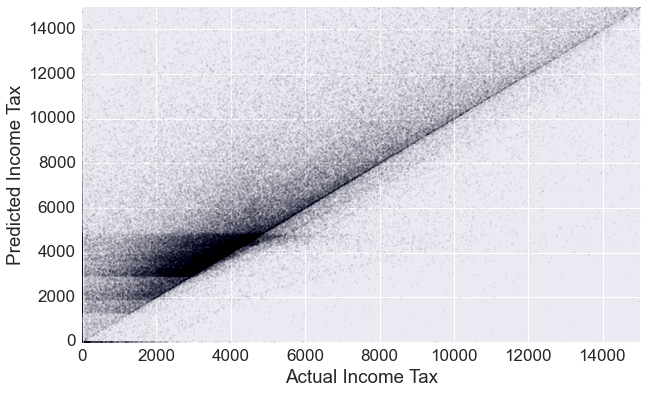

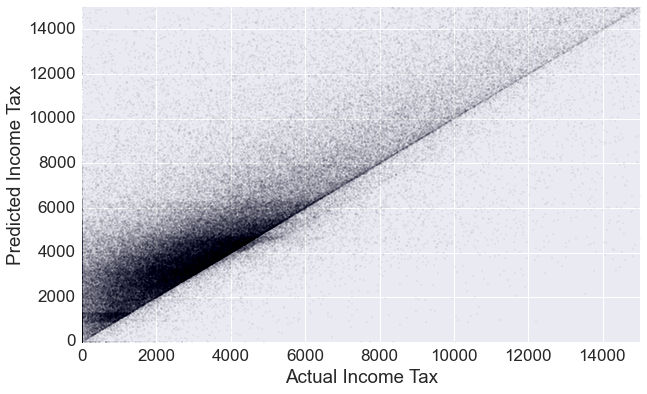

In [130]:
sns.set(font_scale = 1.7)
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,6))
plt.scatter(df_temp.ZIMPOM14_2014,df_temp.Irpp_2014, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")
df_temp = df.query("(NBPAC_2011 >=0) & (NBPAC_2011==NBPAC_2014) ")
print(df_temp.shape)
fig = plt.figure(figsize=(10,6))
plt.scatter(df_temp.ZIMPOM_2011,df_temp.Irpp_2011, s=0.02 )
plt.xlim(0,15000) ; plt.xlabel("Actual Income Tax")
plt.ylim(0,15000) ; plt.ylabel("Predicted Income Tax")

In [131]:
regression_delta_zimpom_formula = " {}  + Not_touched_by_reform*C(NBPAC_2011)- Not_touched_by_reform-C(NBPAC_2011)"\
"+ Delta_Rbg_times_not_touched_reform/C(NBPAC_2011)-Delta_Rbg_times_not_touched_reform"\
"-1".format(
        ' + '.join( interactions_child_over+ interactions_child_between+interactions_rbg_over+interactions_rbg_between))

In [132]:


df["Not_touched_by_reform"] = (df.NBPAC_2011 == 0).astype("int")
for nb_enf in range(1,7): ### in modification
    df["Not_touched_by_reform".format(nb_enf)
          ] +=((df.Rbg_2011<  threshold_byr_rbg["2014"].iloc[nb_enf-1])
                *( df.NBPAC_2011 == nb_enf)).astype("float")

In [133]:
m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df)
fit1 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVALM_2011<50)"))
fit2 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)"))
fit3 = m.fit()


m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"))
fit4 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query("(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)"\
                                 "&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)"\
                                 "&(ZVALM_2011<50)" \
                                ))
fit5 = m.fit()

m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query(("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)"))
                        )
fit6 = m.fit()


m = sm.OLS.from_formula("(Delta_ZIMPOM)~  "+ regression_delta_zimpom_formula,
                        df.query(("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==0)"))
                        )
fit7 = m.fit()



In [134]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").Delta_ZIMPOM.mean()* 0.128

187.35313193021668

In [135]:
summary_col = summary_col([fit1, fit2,fit3, fit4, fit5, fit6, fit7], stars = True,float_format='%.3f',
                  info_dict=info_dict)

In [136]:
print(summary_col)


                                                      Delta_ZIMPOM I Delta_ZIMPOM II Delta_ZIMPOM III Delta_ZIMPOM IIII Delta_ZIMPOM IIIII Delta_ZIMPOM IIIIII Delta_ZIMPOM IIIIIII
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Interactions_child1_over                              1224.397***    1054.033***     1220.851***      1182.230***       1138.669***        908.510***          907.230***          
                                                      (39.269)       (34.399)        (40.883)         (35.480)          (31.176)           (53.015)            (80.654)            
Interactions_child2_over                              1987.648***    1815.497***     1978.035***      2043.818***       1859.081***        1525.396***         1727.364***         
                                                      (30.691)       (27.459)        (32.125)      

In [137]:
print(summary_col.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lccccccc}
\hline
                                                      & Delta_ZIMPOM I & Delta_ZIMPOM II & Delta_ZIMPOM III & Delta_ZIMPOM IIII & Delta_ZIMPOM IIIII & Delta_ZIMPOM IIIIII & Delta_ZIMPOM IIIIIII  \\
\hline
\hline
\end{tabular}
\begin{tabular}{llllllll}
Interactions_child1_over                              & 1224.397***    & 1054.033***     & 1220.851***      & 1182.230***       & 1138.669***        & 908.510***          & 907.230***            \\
                                                      & (39.269)       & (34.399)        & (40.883)         & (35.480)          & (31.176)           & (53.015)            & (80.654)              \\
Interactions_child2_over                              & 1987.648***    & 1815.497***     & 1978.035***      & 2043.818***       & 1859.081***        & 1525.396***         & 1727.364***           \\
                                                      & (30.691)       & (27.459)

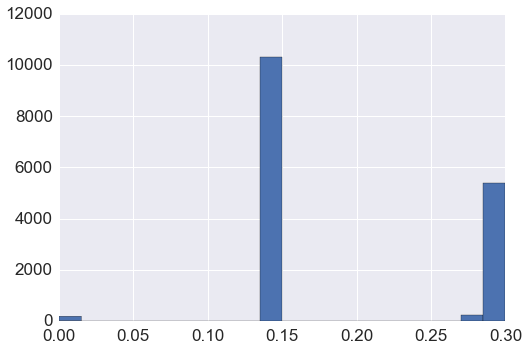

In [138]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").MTR_2014.hist(bins = 20)

In [139]:
df["Delta_Rbg_times_not_touched_reform"] = df.Not_touched_by_reform * df.Delta_Rbg

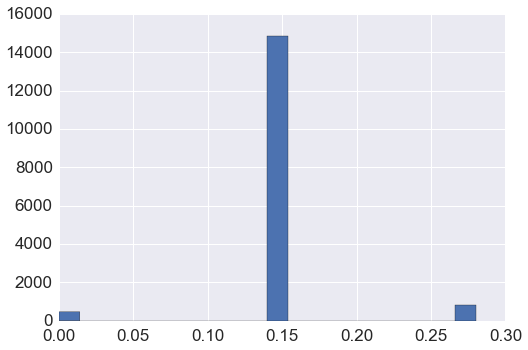

In [140]:
df.query("(Not_touched_by_reform==1)&(NBPAC_2011==1)").Counterfactual_MTR_2011.hist(bins = 20)

In [141]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between)),
       df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)").sample(frac = 1))
fit = m.fit()
fit.conf_int()


summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3097.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:20:10   Log-Likelihood:            -6.2713e+05
No. Observations:               69144   AIC:                         1.254e+06
Df Residuals:                   69113   BIC:                         1.255e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [142]:
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &   Delta_ZIMPOM   & \textbf{  R-squared:         } &      0.573    \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &      0.573    \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &      3097.    \\
\textbf{Date:}                                    & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00     \\
\textbf{Time:}                                    &     11:20:10     & \textbf{  Log-Likelihood:    } & -6.2713e+05   \\
\textbf{No. Observations:}                        &       69144      & \textbf{  AIC:               } &  1.254e+06    \\
\textbf{Df Residuals:}                            &       69113      & \textbf{  BIC:               } &  1.255e+06    \\
\textbf{Df Model:}                                &          30      & \textbf{                     } &    

In [143]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between))
                                                                                        , df.sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     6083.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:20:14   Log-Likelihood:            -1.8898e+06
No. Observations:              193555   AIC:                         3.780e+06
Df Residuals:                  193529   BIC:                         3.780e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [144]:
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &   Delta_ZIMPOM   & \textbf{  R-squared:         } &       0.450     \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &       0.450     \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &       6083.     \\
\textbf{Date:}                                    & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &       0.00      \\
\textbf{Time:}                                    &     11:20:14     & \textbf{  Log-Likelihood:    } &  -1.8898e+06    \\
\textbf{No. Observations:}                        &      193555      & \textbf{  AIC:               } &   3.780e+06     \\
\textbf{Df Residuals:}                            &      193529      & \textbf{  BIC:               } &   3.780e+06     \\
\textbf{Df Model:}                                &          26      & \textbf{              

In [145]:
df.Between_thresholds.head()

0    1
1    0
2    0
3    0
4    0
Name: Between_thresholds, dtype: int32

In [146]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between))
                                                                                        , df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)").sample(frac = 1))
fit = m.fit()
fit.conf_int()
summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     4724.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:20:17   Log-Likelihood:            -7.9791e+05
No. Observations:               87773   AIC:                         1.596e+06
Df Residuals:                   87741   BIC:                         1.596e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [147]:
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &   Delta_ZIMPOM   & \textbf{  R-squared:         } &      0.625    \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &      0.625    \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &      4724.    \\
\textbf{Date:}                                    & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00     \\
\textbf{Time:}                                    &     11:20:17     & \textbf{  Log-Likelihood:    } & -7.9791e+05   \\
\textbf{No. Observations:}                        &       87773      & \textbf{  AIC:               } &  1.596e+06    \\
\textbf{Df Residuals:}                            &       87741      & \textbf{  BIC:               } &  1.596e+06    \\
\textbf{Df Model:}                                &          31      & \textbf{                     } &    

In [148]:

df_expetcted_values = pd.DataFrame()
df_expetcted_values.loc["Over_lumpsum_1","expected_same_rbg2"] = 836
df_expetcted_values.loc["Over_lumpsum_2","expected_same_rbg2"] = 836 * 2 
df_expetcted_values.loc["Over_lumpsum_3","expected_same_rbg2"] = 836 * 4 
df_expetcted_values.loc["Over_lumpsum_4","expected_same_rbg2"] = 836 * 6
df_expetcted_values.loc["Over_lumpsum_5","expected_same_rbg2"] = 836 * 8

df_expetcted_values.loc["Over_lumpsum_1","expected_same_rbg"] = df.query("Interactions_child1_over == 1").Irpp_2011.mean() - df.query("Interactions_child1_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_2","expected_same_rbg"] = df.query("Interactions_child2_over == 1").Irpp_2011.mean() - df.query("Interactions_child2_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_3","expected_same_rbg"] = df.query("Interactions_child3_over == 1").Irpp_2011.mean() - df.query("Interactions_child3_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_4","expected_same_rbg"] = df.query("Interactions_child4_over == 1").Irpp_2011.mean() - df.query("Interactions_child4_over == 1").Counterfactual_Irpp_2011.mean() 
df_expetcted_values.loc["Over_lumpsum_5","expected_same_rbg"] = df.query("Interactions_child5_over == 1").Irpp_2011.mean() - df.query("Interactions_child5_over == 1").Counterfactual_Irpp_2011.mean() 



df_expetcted_values.loc["Between_lumpsum_1","expected_same_rbg"] =30
df_expetcted_values.loc["Between_lumpsum_2","expected_same_rbg"] = 836 * 2 
df_expetcted_values.loc["Between_lumpsum_3","expected_same_rbg"] = 836 * 4 
df_expetcted_values.loc["Between_lumpsum_4","expected_same_rbg"] = 836 * 6
df_expetcted_values.loc["Between_lumpsum_5","expected_same_rbg"] = 836 * 8



df_expetcted_values.loc["Over_lumpsum_1","expected"] = 836
df_expetcted_values.loc["Over_lumpsum_2","expected"] = 836 * 2 
df_expetcted_values.loc["Over_lumpsum_3","expected"] = 836 * 4 
df_expetcted_values.loc["Over_lumpsum_4","expected"] = 836 * 6
df_expetcted_values.loc["Over_lumpsum_5","expected"] = 836 * 8


df_expetcted_values.loc["Over_MTR_1", "expected"] = df.query("Interactions_child1_over == 1").MTR_2014.mean() 
df_expetcted_values.loc["Over_MTR_2", "expected"] = df.query("Interactions_child2_over == 1").MTR_2014.mean()
df_expetcted_values.loc["Over_MTR_3", "expected"] = df.query("Interactions_child3_over == 1").MTR_2014.mean() 
df_expetcted_values.loc["Over_MTR_4", "expected"] = df.query("Interactions_child4_over == 1").MTR_2014.mean()
df_expetcted_values.loc["Over_MTR_5", "expected"] = df.query("Interactions_child5_over == 1").MTR_2014.mean()


df_expetcted_values.loc["Between_MTR_1", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 1)").MTR_2014.mean() 
df_expetcted_values.loc["Between_MTR_2", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 2)").MTR_2014.mean()
df_expetcted_values.loc["Between_MTR_3", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 3)").MTR_2014.mean() 
df_expetcted_values.loc["Between_MTR_4", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 4)").MTR_2014.mean()
df_expetcted_values.loc["Between_MTR_5", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 5)").MTR_2014.mean()

df_expetcted_values.loc["Not_touched_by_reform", "expected"] = 18
df_expetcted_values.loc["Not_touched_by_reform_MTR", "expected"] = df.query("Not_touched_by_reform == True").MTR_2014.mean()






df_expetcted_values.loc["Over_lumpsum_1","expected"] = (df.query("Interactions_child1_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child1_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_2","expected"] = (df.query("Interactions_child2_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child2_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_3","expected"] = (df.query("Interactions_child3_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child3_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_4","expected"] = (df.query("Interactions_child4_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child4_over == 1").Irpp_2011).mean()
df_expetcted_values.loc["Over_lumpsum_5","expected"] = (df.query("Interactions_child5_over == 1").Counterfactual_Irpp_2014 
                                                        - df.query("Interactions_child5_over == 1").Irpp_2011).mean()


df_expetcted_values.loc["Over_MTR_1", "expected"] = df.query("Interactions_child1_over == 1").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Over_MTR_2", "expected"] = df.query("Interactions_child2_over == 1").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Over_MTR_3", "expected"] = df.query("Interactions_child3_over == 1").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Over_MTR_4", "expected"] = df.query("Interactions_child4_over == 1").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Over_MTR_5", "expected"] = df.query("Interactions_child5_over == 1").Counterfactual_MTR_2011.mean()


df_expetcted_values.loc["Between_MTR_1", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 1)").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Between_MTR_2", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 2)").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Between_MTR_3", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 3)").Counterfactual_MTR_2011.mean() 
df_expetcted_values.loc["Between_MTR_4", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 4)").Counterfactual_MTR_2011.mean()
df_expetcted_values.loc["Between_MTR_5", "expected"] = df.query("(Between_thresholds==1)& (NBPAC_2011 == 5)").Counterfactual_MTR_2011.mean()

df_expetcted_values.loc["Not_touched_by_reform", "expected"] = 18
df_expetcted_values.loc["Not_touched_by_reform_MTR", "expected"] = df.query("Not_touched_by_reform == True").Counterfactual_MTR_2014.mean()








# df_expetcted_values["OLS"] = fit.params.values
# df_expetcted_values["Delta_OLS"] = df_expetcted_values["OLS"]-df_expetcted_values["expected"]

In [149]:
fit.params.describe

<bound method Series.describe of Interactions_child1_over                     1138.668897
Interactions_child2_over                     1859.081007
Interactions_child3_over                     3184.281197
Interactions_child4_over                     5119.359370
Interactions_child5_over                     6920.581010
Interactions_child6_over                     6154.763135
Interactions_rbg_child1_over                    0.249042
Interactions_rbg_child2_over                    0.275315
Interactions_rbg_child3_over                    0.304584
Interactions_rbg_child4_over                    0.327581
Interactions_rbg_child5_over                    0.404251
Interactions_rbg_child6_over                    0.388969
Interactions_rbg_child1_between                 0.183153
Interactions_rbg_child2_between                 0.222697
Interactions_rbg_child3_between                 0.230030
Interactions_rbg_child4_between                 0.233436
Interactions_rbg_child5_between                 0.22522

In [150]:

ir_2011.ir_avec_plafond_qf_enfant(np.array([85000]), np.array([0.5]))-  ir_2014.ir_avec_plafond_qf_enfant(np.array([85000]), np.array([0.5]))

array([-680.97])

In [151]:
df_expetcted_values

expected_same_rbg2  expected_same_rbg     expected
Over_lumpsum_1                            836        -669.766751  1267.204433
Over_lumpsum_2                           1672       -1488.925320  2065.162118
Over_lumpsum_3                           3344       -3111.518390  2824.891414
Over_lumpsum_4                           5016       -4719.088800  3658.975696
Over_lumpsum_5                           6688       -6285.332310  4851.605929
Between_lumpsum_1                         NaN          30.000000          NaN
Between_lumpsum_2                         NaN        1672.000000          NaN
Between_lumpsum_3                         NaN        3344.000000          NaN
Between_lumpsum_4                         NaN        5016.000000          NaN
Between_lumpsum_5                         NaN        6688.000000          NaN
Over_MTR_1                                NaN                NaN     0.305823
Over_MTR_2                                NaN                NaN     0.309416
Over_MTR_3                                NaN                NaN     0.324800
Over_MTR_4                                NaN                NaN     0.347988
Over_MTR_5                                NaN                NaN     0.394286
Between_MTR_1                             NaN                NaN     0.285048
Between_MTR_2                             NaN                NaN     0.292524
Between_MTR_3                             NaN                NaN     0.294966
Between_MTR_4                             NaN                NaN     0.295672
Between_MTR_5                             NaN                NaN     0.292920
Not_touched_by_reform                     NaN                NaN    18.000000
Not_touched_by_reform_MTR                 NaN                NaN     0.184606

In [152]:

# df["Treatment_0_2011"] = False * df.shape[0]



# df["Treatment_1_2011"] = False * df.shape[0]


# df["Treatment_2_2011"] = False * df.shape[0]
# for child in range(1,7):

#     df["Treatment_1_2011"] += (df.NBPAC_2011 == child) * df["Between_threshold_{}_child".format(child)]
    

#     df["Treatment_2_2011"] += (df.NBPAC_2011 == child) * df["Over_threshold_{}_child".format(child)]
# df["Treatment_1_2011"] = df["Treatment_1_2011"].astype("bool")
# df["Treatment_2_2011"] = df["Treatment_2_2011"].astype("bool")
# df["Treatment_0_2011"] = ~(df.Treatment_1_2011 |df_start.Treatment_2_2011)

# print(df.query("Treatment_1_2011==1").Counterfactual_MTR_2011.mean())
# print(df.query("Between_thresholds==1").Counterfactual_MTR_2011.mean())

### Graphs MTR

In [153]:
import matplotlib

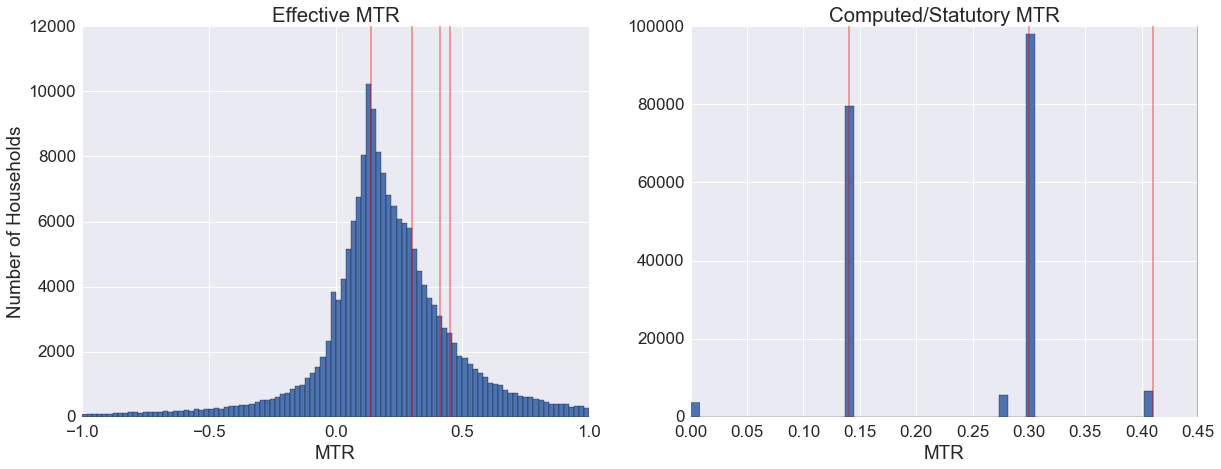

In [154]:
sns.set(font_scale = 1.7)
df["Real_MTR_from_Zimpom"] = (df.ZIMPOM14_2014 - df.ZIMPOM_2011)/(df.Rbg_2014 - df.Rbg_2011)
plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
df.query("(-1<Real_MTR_from_Zimpom<1)").Real_MTR_from_Zimpom.hist(bins = 100)
y_min, y_max = plt.ylim()
plt.axvline(0.3,  color = 'r',alpha = 0.4)
plt.axvline(0.14, color = 'r',alpha = 0.4)
plt.axvline(0.41, color = 'r',alpha = 0.4)
plt.axvline(0.45, color = 'r',alpha = 0.4)
plt.ylabel("Number of Households")
plt.xlabel("MTR")
plt.title("Effective MTR")
plt.subplot(1,2,2)
plt.title("Computed/Statutory MTR")
df.MTR_2014.hist(bins = 51)
plt.axvline(0.3,  color = 'r',alpha = 0.4)
plt.axvline(0.14, color = 'r',alpha = 0.4)
plt.axvline(0.41, color = 'r',alpha = 0.4)
plt.axvline(0.45, color = 'r',alpha = 0.4)
plt.xlabel("MTR")

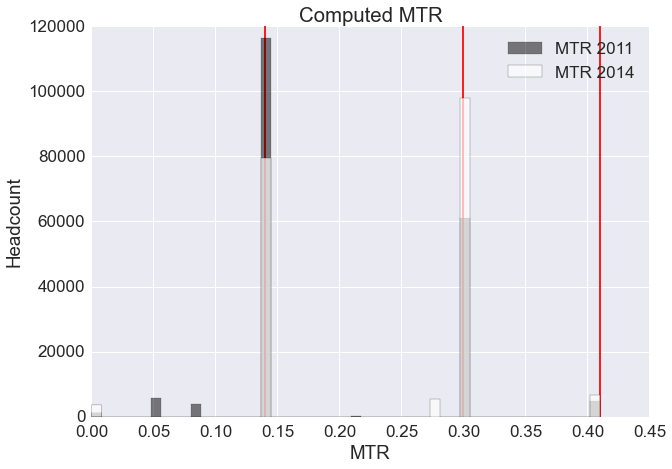

In [155]:
#Transformer en barplot plutpot qu'en hist
import matplotlib as mpl
import matplotlib.patches as mpatches

# mpl.rcParams["hatch.color"] = "white"
# mpl.rcParams['hatch.linewidth'] = 2

fig,ax = plt.subplots(figsize = (10,7))

plt.title("Computed MTR")
df.MTR_2011.hist(bins = 51, color = (0,0,0,0), alpha=0.5, zorder = 3, label = "MTR 2011")
#df.MTR_2011.hist(bins = 51, color = "k", alpha=0.7, zorder = 1, )

plt.axvline(0.3,  color = 'red',)
plt.axvline(0.14, color = 'red',)
plt.axvline(0.41, color = 'red',)


plt.title("Computed MTR")
df.MTR_2014.hist(bins = 51, color = "w", alpha=0.7, zorder = 4, label = "MTR 2014")

#ax.set_xticks([0, 0.055, 0.14, 0.28, 0.3, 0.41])
plt.xlabel("MTR")
plt.ylabel("Headcount")
plt.legend()


In [156]:
df.MTR_2011.value_counts().iloc[:7]

0.140    116381
0.300     60927
0.055      5883
0.410      4923
0.083      2220
0.082      1784
0.000      1269
dtype: int64

In [157]:
5.5*1.5

8.25

In [158]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts().iloc[:8]); df_mtr_2011
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)]

In [159]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts().iloc[:8]); print(df.MTR_2011).value_counts().head(11)
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.MTR_2014).value_counts().iloc[:5]); df_mtr_2014
pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"]).fillna(0)

0.140    116381
0.300     60927
0.055      5883
0.410      4923
0.083      2220
0.082      1784
0.000      1269
0.210       116
0.191         4
0.065         3
0.063         3
dtype: int64


02011  02014
0.000    1269   3653
0.055    5883      0
0.083    4004      0
0.140  116381  79607
0.210     116      0
0.280       0   5597
0.300   60927  97947
0.410    4923   6679

In [160]:
df_mtr_2011 = pd.DataFrame((df.MTR_2011).value_counts(normalize = True).iloc[:8]); df_mtr_2011
df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.MTR_2014).value_counts(normalize = True).iloc[:5]); df_mtr_2014
df_mtr_merged = pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"])
print("Real_MTR")
df_mtr_merged.loc["Total"] = df_mtr_merged.sum(); df_mtr_merged.fillna(0)

Real_MTR


02011     02014
0.0    0.006556  0.018873
0.055  0.030394  0.000000
0.083  0.020687  0.000000
0.14   0.601281  0.411289
0.21   0.000599  0.000000
0.28   0.000000  0.028917
0.3    0.314779  0.506042
0.41   0.025435  0.034507
Total  0.999731  0.999628

In [161]:
df_mtr_2011 = pd.DataFrame((df.Counterfactual_MTR_2011).value_counts(normalize = False).iloc[:8])
#df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.Counterfactual_MTR_2014).value_counts(normalize = False).iloc[:5])
print("Counterfactual MTR")
pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"]).fillna(0)

Counterfactual MTR


02011   02014
0.00   9491       0
0.05      0    1626
0.08      0    1339
0.14  88490  107238
0.18      8       0
0.20      6       0
0.21      7       0
0.28  11459       0
0.30  79432   74776
0.41   4619    7079

In [162]:
df_mtr_2011 = pd.DataFrame((df.Counterfactual_MTR_2011).value_counts(normalize = True).iloc[:8])
#df_mtr_2011.loc[0.083] =df_mtr_2011.loc[0.083]+df_mtr_2011.loc[0.082];df_mtr_2011=  df_mtr_2011[~(df_mtr_2011.index == 0.082)] #put MTR 0.082 with 0.083 actual value 0.825
df_mtr_2014 = pd.DataFrame((df.Counterfactual_MTR_2014).value_counts(normalize = True).iloc[:5])
print("Counterfactual MTR")
pd.merge(df_mtr_2011,df_mtr_2014, left_index = True, right_index = True, how = "outer", suffixes = ["2011", "2014"]).fillna(0)

Counterfactual MTR


02011     02014
0.00  0.049035  0.000000
0.05  0.000000  0.008401
0.08  0.000000  0.006918
0.14  0.457183  0.554044
0.18  0.000041  0.000000
0.20  0.000031  0.000000
0.21  0.000036  0.000000
0.28  0.059203  0.000000
0.30  0.410385  0.386329
0.41  0.023864  0.036574

In [163]:
df["Distance_to_treatment_2"]  = 0
for child in range(1,nb_enf_max_for_annalysis+1):
    df["Distance_to_treatment_2"] += (df["Over_threshold_{}_child".format(child)] * df[child_bool_list[child-1]] 
                                     * ((threshold_byr_rbg["2011"].iloc[child-1]) - df.Rbg_2011))
df["Distance_to_treatment_2"] = np.abs(df["Distance_to_treatment_2"])

In [164]:
76034-94451

-18417

In [165]:
df["Distance_to_treatment_1"]  = 0
for child in [2]:
    df["Distance_to_treatment_1"] += (df[child_bool_list[child-1]]*(df["Over_threshold_{}_child".format(child)])
                                     * (threshold_byr_rbg["2011"].iloc[child-1] - df.Rbg_2011))
df["Distance_to_treatment_1"] = np.abs(df["Distance_to_treatment_1"])




df["Distance_to_treatment_2"]  = 0
for child in range(1,nb_enf_max_for_annalysis+1):
    df["Distance_to_treatment_2"] += (df[child_bool_list[child-1]]*(df["Over_threshold_{}_child".format(child)])
                                     * (threshold_byr_rbg["2011"].iloc[child-1] - df.Rbg_2011))
df["Distance_to_treatment_2"] = np.abs(df["Distance_to_treatment_2"])

In [166]:
m = sm.OLS.from_formula("(Delta_Rbg)~   {} + I(Distance_to_treatment_2**2)".format(
        ' + '.join(
                  children_number + flatten_thresholds_list
                + interaction_child_between_threshold + interaction_child_over_threshold)),
        df)
fit = m.fit(cov_type="HC1")
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              Delta_Rbg   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     306.6
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:20:27   Log-Likelihood:            -2.1329e+06
No. Observations:              193555   AIC:                         4.266e+06
Df Residuals:                  193523   BIC:                         4.266e+06
Df Model:                          31                                         
Covariance Type:                  HC1                                         
                                                coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------

In [167]:
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &   Delta_ZIMPOM   & \textbf{  R-squared:         } &      0.625    \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &      0.625    \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &      4724.    \\
\textbf{Date:}                                    & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00     \\
\textbf{Time:}                                    &     11:20:17     & \textbf{  Log-Likelihood:    } & -7.9791e+05   \\
\textbf{No. Observations:}                        &       87773      & \textbf{  AIC:               } &  1.596e+06    \\
\textbf{Df Residuals:}                            &       87741      & \textbf{  BIC:               } &  1.596e+06    \\
\textbf{Df Model:}                                &          31      & \textbf{                     } &    

In [168]:
### To_keep article !!
m = sm.OLS.from_formula("(Delta_ZIMPOM)~   {} - 1 + Not_touched_by_reform:C(NBPAC_2011) + Delta_Rbg_times_not_touched_reform".format(
        ' + '.join( interactions_child_over+interactions_rbg_over+interactions_rbg_between+interactions_child_between)),
       df.query("(ZVALM_2011<50)&(ZIMPOM_2011>500)&(ZIMPOM14_2014>500)&(ZVAMM_2011<200)& (ZRACM_2011<200) & (ZETRM_2011<100)&(Delta_rbg_positif==1)").sample(frac = 1))
fit = m.fit()
fit.conf_int()


summary = fit.summary(alpha = 0.01); print(summary)

                            OLS Regression Results                            
Dep. Variable:           Delta_ZIMPOM   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3097.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:20:29   Log-Likelihood:            -6.2713e+05
No. Observations:               69144   AIC:                         1.254e+06
Df Residuals:                   69113   BIC:                         1.255e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [99.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [169]:
print(summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}                           &   Delta_ZIMPOM   & \textbf{  R-squared:         } &      0.573    \\
\textbf{Model:}                                   &       OLS        & \textbf{  Adj. R-squared:    } &      0.573    \\
\textbf{Method:}                                  &  Least Squares   & \textbf{  F-statistic:       } &      3097.    \\
\textbf{Date:}                                    & Thu, 06 Jun 2019 & \textbf{  Prob (F-statistic):} &      0.00     \\
\textbf{Time:}                                    &     11:20:29     & \textbf{  Log-Likelihood:    } & -6.2713e+05   \\
\textbf{No. Observations:}                        &       69144      & \textbf{  AIC:               } &  1.254e+06    \\
\textbf{Df Residuals:}                            &       69113      & \textbf{  BIC:               } &  1.255e+06    \\
\textbf{Df Model:}                                &          30      & \textbf{                     } &    

In [170]:
print datetime.datetime.now()

2019-06-06 11:20:29.689000
